# Individual End-to-End Machine Learning Project to Predict Movie Ratings
Candidate ID: MPZY3

# 1 Installing libraries

In [5]:
!pip install -q missingno
!pip install -q tensorflow
!pip install keras-tuner
!pip install xgboost
!pip install --upgrade scikit-learn

In [1]:
# Importing libraries for data processing, visualization, and deep learning
import joblib
import pickle
import random
import shutil
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno
import tensorflow as tf
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.experimental import enable_halving_search_cv
from sklearn.model_selection import train_test_split, GridSearchCV, HalvingGridSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from xgboost import XGBRegressor
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import Input, Embedding, Flatten, Dense, Concatenate, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import LeakyReLU, Activation
from tensorflow.keras.regularizers import l2
from tensorflow.keras.activations import swish
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, LearningRateScheduler
from keras_tuner import RandomSearch

Setting the global seed for the Python notebook to ensure reproducibility of results.

In [4]:
# Ensuring reproducibility by setting fixed random seeds
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
random.seed(RANDOM_SEED)
tf.random.set_seed(RANDOM_SEED)
os.environ['PYTHONHASHSEED'] = str(RANDOM_SEED)

# Ensure deterministic operations in TensorFlow
os.environ["TF_DETERMINISTIC_OPS"] = "1"

# 2 Loading Dataset and Data Preprocessing

In [6]:
# Loading datasets
ratings_path = "./Datasets/ratings.csv"
movies_path = "./Datasets/movies.csv"

ratings_df = pd.read_csv(ratings_path)  # User ratings data
movies_df = pd.read_csv(movies_path)  # Movie metadata (title, genres)

In [8]:
# Check for missing values in each dataset
print("Missing values before cleaning:")
print(ratings_df.isnull().sum())
print(movies_df.isnull().sum())

Missing values before cleaning:
userId       0
movieId      0
rating       0
timestamp    0
dtype: int64
movieId    0
title      0
genres     0
dtype: int64


User IDs and Movie IDs are categorical data that need to be encoded and transformed into numerical values for neural network training.

In [11]:
# Convert IDs to numerical format for neural network training
user_encoder = LabelEncoder()
movie_encoder = LabelEncoder()

ratings_df["userId"] = user_encoder.fit_transform(ratings_df["userId"])
ratings_df["movieId"] = movie_encoder.fit_transform(ratings_df["movieId"])

Since there are two datasets of interest: ratings and movies, we need to merge these to create a comprehensive dataset.

In [13]:
# Convert genres into separate binary columns and merge
movies_df = movies_df.drop(columns=["genres"]).join(movies_df["genres"].str.get_dummies(sep="|"))

# Merge ratings with movies and drop rows where 'title' is NaN
df = ratings_df.merge(movies_df, on="movieId", how="left").dropna(subset=["title"])

# Check for missing values
print("Missing values after fixing:", df.isnull().sum().sum())  # Should print 0

Missing values after fixing: 0


In [15]:
df.head()

,userId,movieId,rating,timestamp,title,(no genres listed),Action,Adventure,Animation,Children,...,Film-Noir,Horror,IMAX,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
1,0,2,4.0,964981247,Jumanji (1995),0.0,0.0,1.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0,5,4.0,964982224,Father of the Bride Part II (1995),0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0,43,5.0,964983815,Restoration (1995),0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0,46,5.0,964982931,How to Make an American Quilt (1995),0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
5,0,62,3.0,964982400,Mr. Holland's Opus (1995),0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [17]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 67160 entries, 1 to 100783
Data columns (total 25 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   userId              67160 non-null  int64  
 1   movieId             67160 non-null  int64  
 2   rating              67160 non-null  float64
 3   timestamp           67160 non-null  int64  
 4   title               67160 non-null  object 
 5   (no genres listed)  67160 non-null  float64
 6   Action              67160 non-null  float64
 7   Adventure           67160 non-null  float64
 8   Animation           67160 non-null  float64
 9   Children            67160 non-null  float64
 10  Comedy              67160 non-null  float64
 11  Crime               67160 non-null  float64
 12  Documentary         67160 non-null  float64
 13  Drama               67160 non-null  float64
 14  Fantasy             67160 non-null  float64
 15  Film-Noir           67160 non-null  float64
 16  Horror  

In [18]:
# Extract the year from the title and create a new column 'release_year'
df["release_year"] = df["title"].str.extract(r"\((\d{4})\)$")  # Extracts 4-digit year in parentheses

# Convert to integer type (some values might be NaN)
df["release_year"] = df["release_year"].astype("Int64")  # Uses Int64 to allow NaN values

In [21]:
# Drop Unnecessary Columns
df.drop(columns=["title", "(no genres listed)"], inplace=True)  # Title and (no genres listed) are not useful for ML

<Axes: >

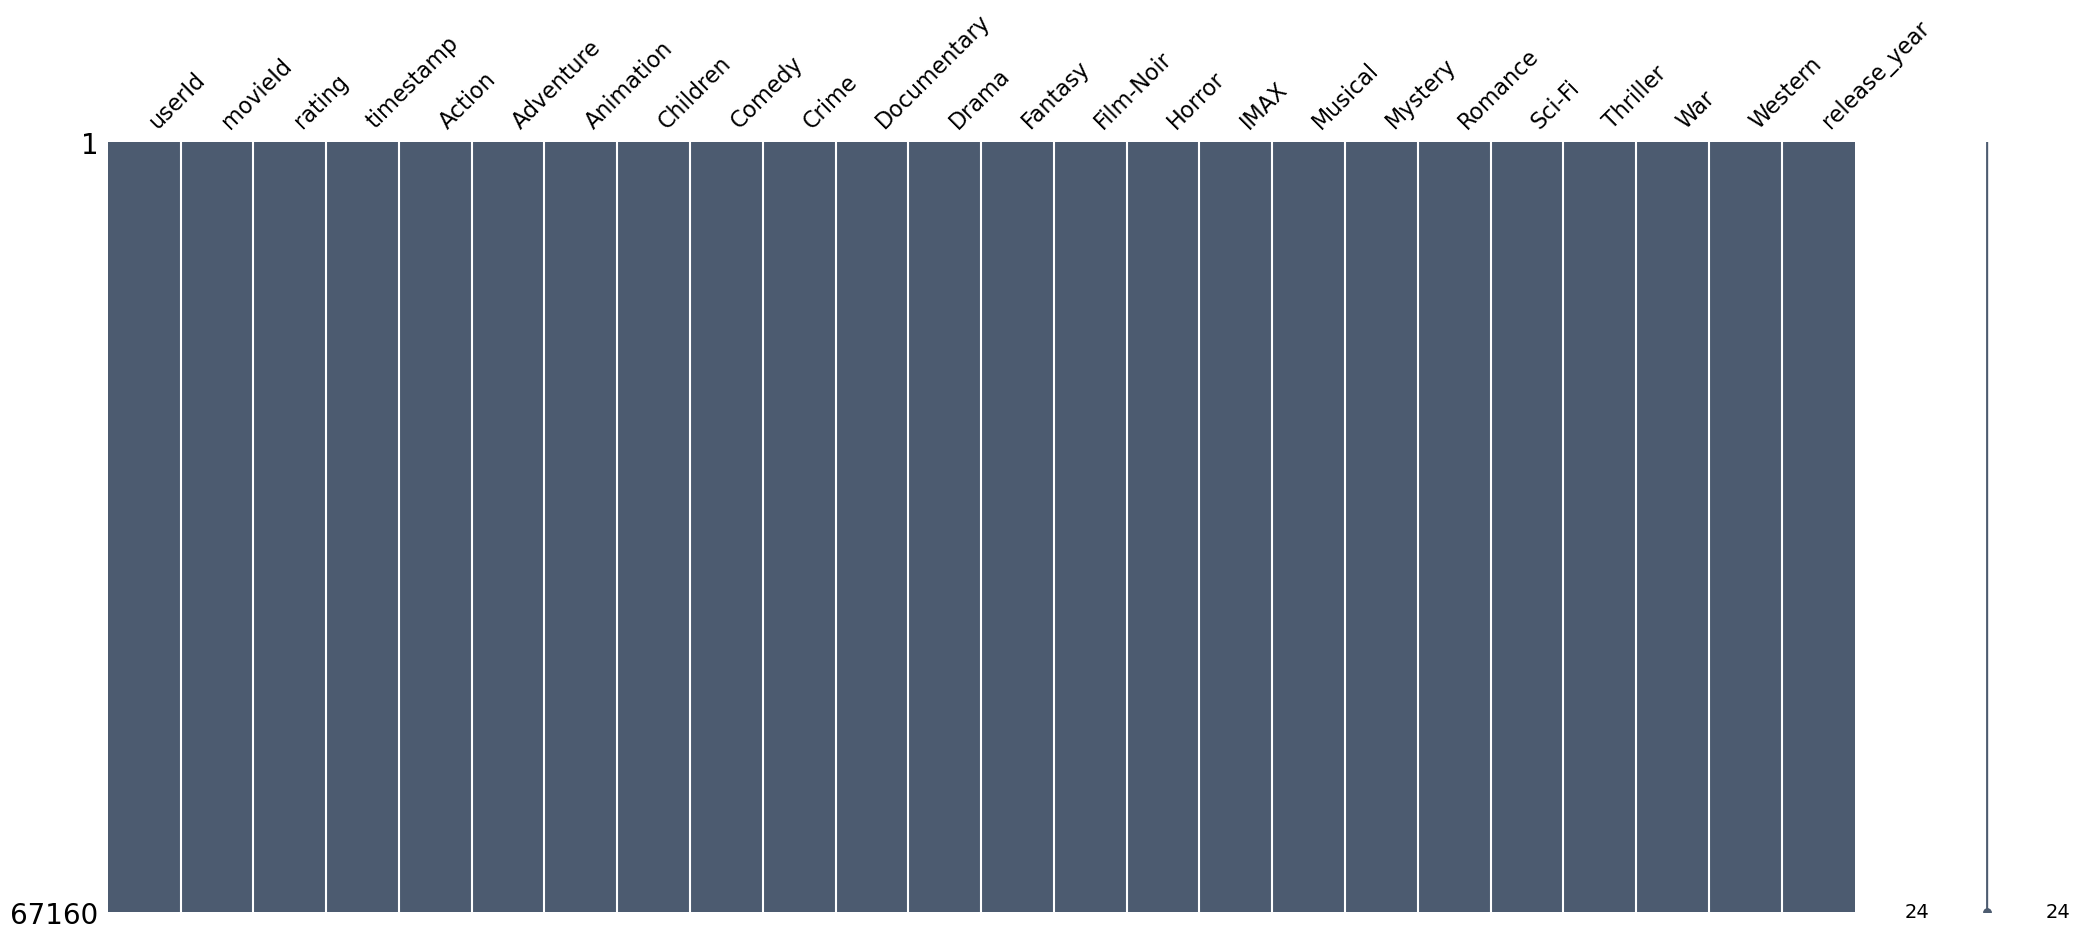

In [23]:
# Checking for missing data
msno.matrix(df, color = (0.3, 0.36, 0.44))

# 3 Exploratory Data Analysis and Outlier Analysis

We start by analysing the distribution of ratings in the dataset. It is observed that the ratings are slightly skewed. Log transformation further skews the data, so we only consider the original variable. Movie ratings are naturally a little skewed since most people rate movies positively (between 3 to 5) and not negatively (between 0 to 2). Machine learning models such as random forests and neural networks can handle such skewedness.

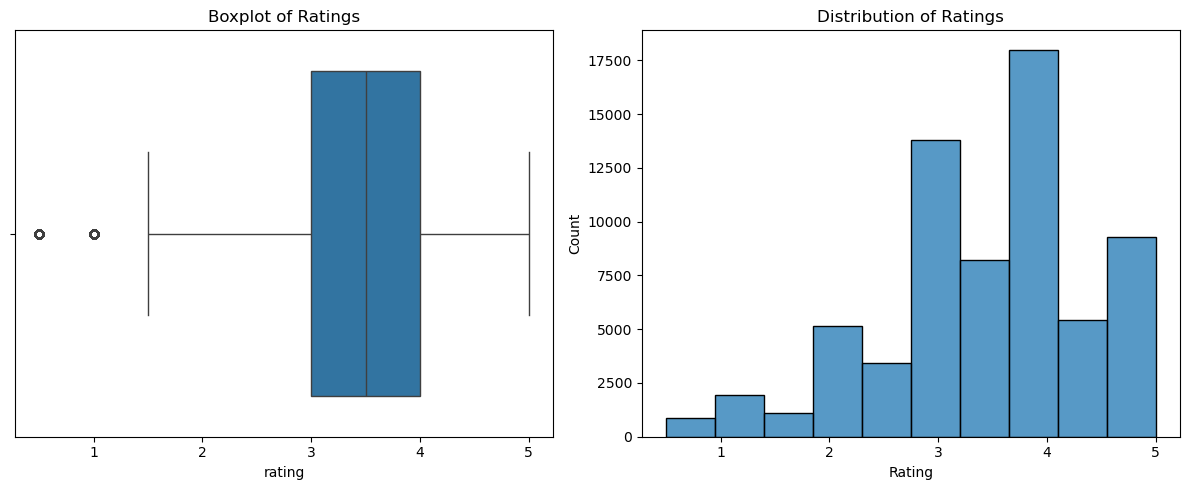

In [27]:
# Create a single figure with subplots for rating distributions
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Boxplot for rating distribution
sns.boxplot(x=df["rating"], ax=axes[0])
axes[0].set_title("Boxplot of Ratings")

# Histogram for rating distribution
sns.histplot(df["rating"], bins=10, ax=axes[1])
axes[1].set_title("Distribution of Ratings")
axes[1].set_xlabel("Rating")
axes[1].set_ylabel("Count")

# Adjust layout for better visibility
plt.tight_layout()
plt.show()

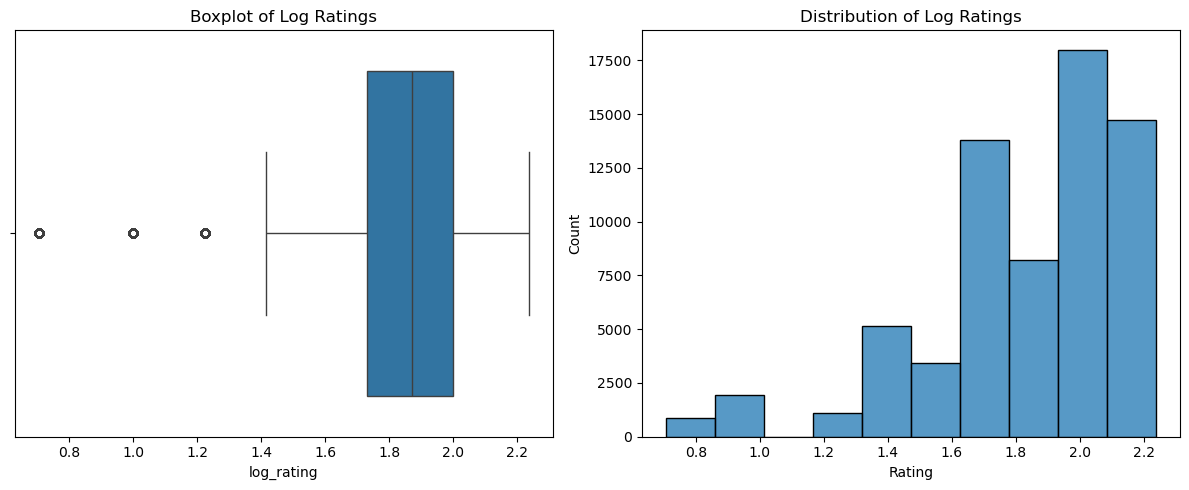

In [29]:
# Log transforming ratings
df["log_rating"] = np.sqrt(df["rating"])

# Create a single figure with subplots for log rating distributions
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Boxplot for rating distribution
sns.boxplot(x=df["log_rating"], ax=axes[0])
axes[0].set_title("Boxplot of Log Ratings")

# Histogram for rating distribution
sns.histplot(df["log_rating"], bins=10, ax=axes[1])
axes[1].set_title("Distribution of Log Ratings")
axes[1].set_xlabel("Rating")
axes[1].set_ylabel("Count")

# Adjust layout for better visibility
plt.tight_layout()
plt.show()

Log transformation further skews the data and so the original variable is retained.

Next, we analyse the distribution of movie genres along with the relevance of each genre.

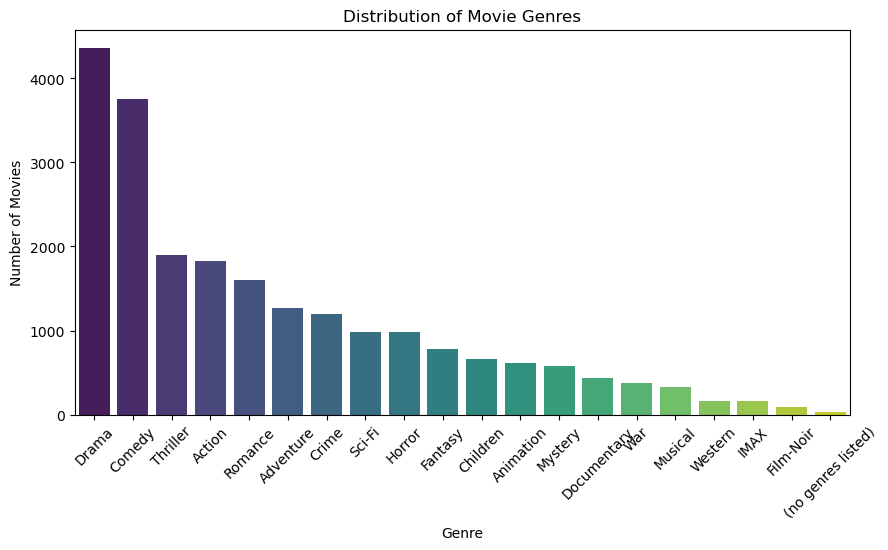

In [32]:
# Plot genre distribution
genre_sums = movies_df.iloc[:, 2:].sum().sort_values(ascending=False)  # Sum of one-hot encoded genres

plt.figure(figsize=(10, 5))
sns.barplot(x=genre_sums.index, y=genre_sums.values, hue=genre_sums.index, palette="viridis")
plt.xticks(rotation=45)
plt.title("Distribution of Movie Genres")
plt.ylabel("Number of Movies")
plt.xlabel("Genre")
plt.show()

The code block below performs an ANOVA analysis to check if the ratings differ significantly across genres. If the p-value is less than 0.05, the ratings for that particular genre as significantly different from those of other genres. While most of the genres are relevant to the analysis, a few like Western, Documentary, Crime along with others do not create differences in ratings. Therefore, their respective columns will be dropped from the dataset before the analysis.

In [35]:
from scipy.stats import f_oneway

# Perform ANOVA analysis to check if ratings significantly differ across genres
genre_columns = movies_df.columns[3:]  # Select all genre columns
anova_results = {}

for genre in genre_columns:
    group1 = df[df[genre] == 1]["rating"]  # Ratings for movies in this genre
    group2 = df[df[genre] == 0]["rating"]  # Ratings for movies not in this genre

    if len(group1) > 1 and len(group2) > 1:  # Ensure valid groups
        stat, p_value = f_oneway(group1, group2)
        anova_results[genre] = p_value

# Display results sorted by significance
anova_results = dict(sorted(anova_results.items(), key=lambda item: item[1]))
print("ANOVA p-values for Genre Rating Differences:")
for genre, p_val in anova_results.items():
    print(f"{genre}: {p_val:.5f}")

ANOVA p-values for Genre Rating Differences:
Mystery: 0.00000
Romance: 0.00000
Comedy: 0.00000
Musical: 0.00000
Horror: 0.00000
IMAX: 0.00000
Drama: 0.00000
Animation: 0.00000
Action: 0.00000
Sci-Fi: 0.00034
Children: 0.00054
Thriller: 0.00090
Fantasy: 0.00093
Film-Noir: 0.00460
Western: 0.10392
Documentary: 0.30598
Crime: 0.42395
War: 0.86685
Adventure: 0.88139


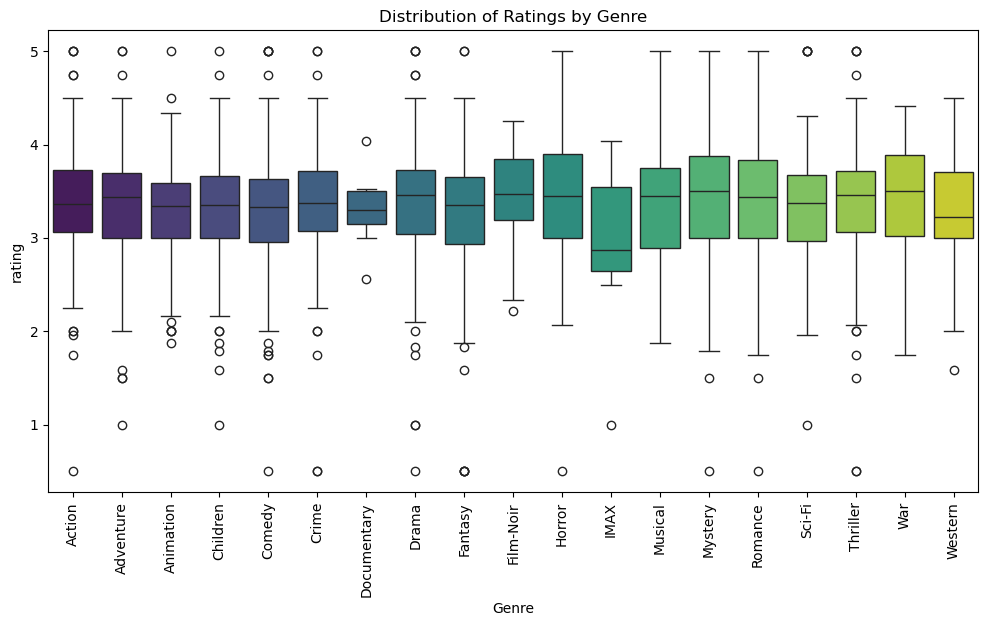

In [36]:
# Compute average rating for each genre
genre_columns = movies_df.columns[3:]  # All genre columns
genre_ratings = df.groupby(genre_columns.tolist())["rating"].mean().reset_index()

# Melt the dataset to make it suitable for visualization
melted_genres = genre_ratings.melt(id_vars=["rating"], var_name="Genre", value_name="IsPresent")
melted_genres = melted_genres[melted_genres["IsPresent"] == 1]  # Keep only rows where genre is present

# Plot
plt.figure(figsize=(12, 6))
sns.boxplot(x="Genre", y="rating", data=melted_genres, hue="Genre", palette="viridis")
plt.xticks(rotation=90)
plt.title("Distribution of Ratings by Genre")
plt.show()

The boxplots above show that while most genres have median ratings around 3 to 4 (favourable 
user feedback), some, such as horror and thriller, have a higher variability, which could
introduce noise.

# 4 Feature Engineering

## 4.1 User-based Features
We start the feature engineering section by creating user-based features such as **average user ratings** and **total number of ratings per user**.

In [41]:
# Compute average rating per user
# - Groups data by 'userId' and calculates the mean rating for each user
df["avg_user_rating"] = df.groupby("userId")["rating"].transform("mean")

# Compute total number of ratings per user
# - Groups data by 'userId' and counts how many ratings each user has provided
df["total_user_ratings"] = df.groupby("userId")["rating"].transform("count")

# Display a preview of the updated dataset
print("User-based features added:")
df.head()

User-based features added:


,userId,movieId,rating,timestamp,Action,Adventure,Animation,Children,Comedy,Crime,...,Mystery,Romance,Sci-Fi,Thriller,War,Western,release_year,log_rating,avg_user_rating,total_user_ratings
1,0,2,4.0,964981247,0.0,1.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1995,2.000000,4.365854,164
2,0,5,4.0,964982224,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1995,2.000000,4.365854,164
3,0,43,5.0,964983815,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1995,2.236068,4.365854,164
4,0,46,5.0,964982931,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,1995,2.236068,4.365854,164
5,0,62,3.0,964982400,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1995,1.732051,4.365854,164


Next, we analyse the new user-based features created by creating boxplots and histograms.

In [44]:
import math

def plot_boxplots(dataframe, columns):
    """
    Creates multiple boxplots with a maximum of 2 per row.
    
    Parameters:
    dataframe (pd.DataFrame): The dataset containing the variables.
    columns (list): A list of column names to plot as boxplots.

    Returns:
    None (Displays the boxplots)
    """
    
    # Determine the number of boxplots to create
    num_plots = len(columns)

    # Calculate the number of rows required (max 2 per row)
    num_rows = math.ceil(num_plots / 2)  # Ensures all subplots fit

    # Set up the figure and subplots (adjusting dynamically)
    fig, axes = plt.subplots(num_rows, 2, figsize=(10, 5 * num_rows))  # 2 columns, variable rows

    # Flatten the axes array for easier iteration (handles single-row case)
    axes = axes.flatten() if num_plots > 1 else [axes]  

    # Generate boxplots for each selected column
    for i, col in enumerate(columns):
        sns.boxplot(x=dataframe[col], ax=axes[i])
        axes[i].set_title(f"Boxplot of {col.replace('_', ' ').title()}")
        axes[i].set_xlabel(col.replace('_', ' ').title())

    # Hide any empty subplots if columns < grid size
    for j in range(i + 1, len(axes)):  # Hide any unused subplots
        fig.delaxes(axes[j])

    # Adjust layout for better visibility
    plt.tight_layout()

    # how the plot
    plt.show()

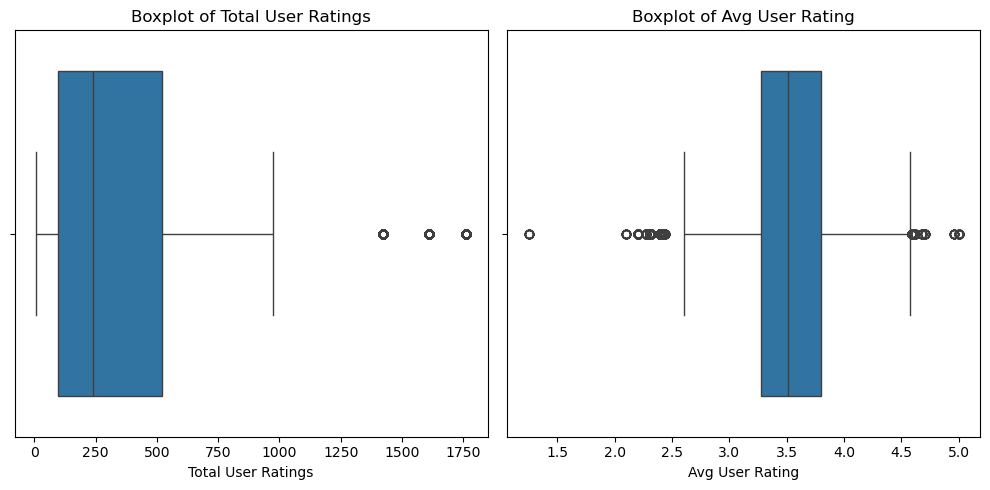

In [46]:
plot_boxplots(df, ["total_user_ratings", "avg_user_rating"])

In [48]:
def plot_histograms(dataframe, columns, bins=30):
    """
    Creates multiple histograms with a maximum of 2 per row.

    Parameters:
    dataframe (pd.DataFrame): The dataset containing the variables.
    columns (list): A list of column names to plot as histograms.
    bins (int): Number of bins for the histogram (default = 30).

    Returns:
    None (Displays the histograms)
    """

    # Determine the number of histograms to create
    num_plots = len(columns)

    # Calculate the number of rows required (max 2 per row)
    num_rows = math.ceil(num_plots / 2)  # Ensures all subplots fit

    # Set up the figure and subplots (adjusting dynamically)
    fig, axes = plt.subplots(num_rows, 2, figsize=(10, 5 * num_rows))  # 2 columns, variable rows

    # Flatten the axes array for easier iteration (handles single-row case)
    axes = axes.flatten() if num_plots > 1 else [axes]  

    # Generate histograms for each selected column
    for i, col in enumerate(columns):
        sns.histplot(dataframe[col], bins=bins, kde=False, ax=axes[i])  # KDE adds a smooth density curve
        axes[i].set_title(f"Distribution of {col.replace('_', ' ').title()}")
        axes[i].set_xlabel(col.replace('_', ' ').title())
        axes[i].set_ylabel("Frequency")

    # Hide any empty subplots if columns < grid size
    for j in range(i + 1, len(axes)):  # Hide any unused subplots
        fig.delaxes(axes[j])

    # Adjust layout for better visibility
    plt.tight_layout()

    # Show the plot
    plt.show()

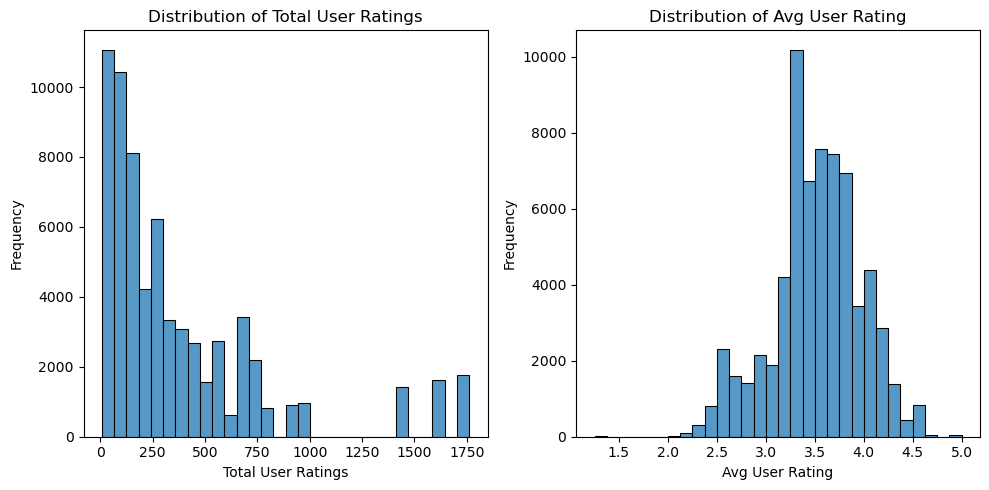

In [49]:
plot_histograms(df, ["total_user_ratings", "avg_user_rating"], bins=30)

Since the total ratings per user variable has a few outliers (seen in boxplot) and is very skewed (seen in histogram), we try log transformation, which removes the skewedness and outliers in the data.

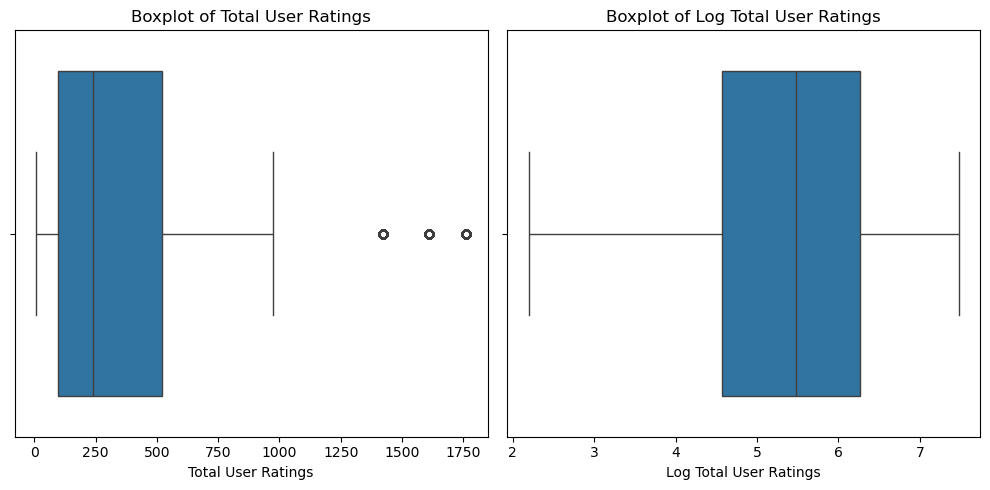

In [53]:
# Create a new column with log transformation
df["log_total_user_ratings"] = np.log1p(df["total_user_ratings"])

# Plot both original and log-transformed variables
plot_boxplots(df, ["total_user_ratings", "log_total_user_ratings"])

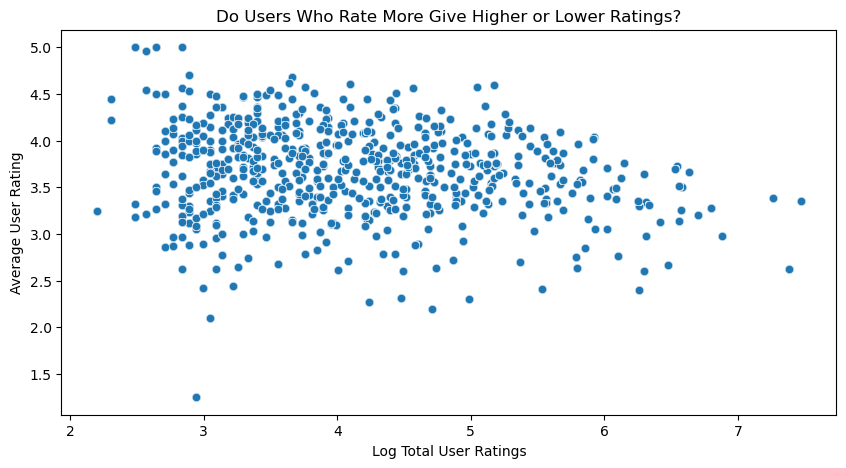

In [55]:
# Scatter plot of total user ratings vs. average rating
plt.figure(figsize=(10, 5))
sns.scatterplot(x=df["log_total_user_ratings"], y=df["avg_user_rating"], alpha=0.5)
plt.title("Do Users Who Rate More Give Higher or Lower Ratings?")
plt.xlabel("Log Total User Ratings")
plt.ylabel("Average User Rating")
plt.show()

The scatter plot examines the relationship between the total number of ratings a user gives (log-transformed) and their average rating, showing that while frequent raters tend to give ratings around the mid-to-high range, there is still significant variability. Understanding this trend helps refine the model by capturing user behavior—frequent raters might have different rating tendencies, which can improve predictions by incorporating user activity as a feature.

## 4.2 Movie-based Features
Next, we create movie-based features such as **average movie rating** and **total number of movie ratings**.

In [58]:
# Compute the average rating for each movie
# - Groups data by 'movieId' and calculates the mean rating for each movie
df["avg_movie_rating"] = df.groupby("movieId")["rating"].transform("mean")

# Compute the total number of ratings each movie has received
# - Groups data by 'movieId' and counts the number of ratings for each movie
df["total_movie_ratings"] = df.groupby("movieId")["rating"].transform("count")

# Display a preview of the updated dataset
print("Movie-based features added:")
df.head()

Movie-based features added:


,userId,movieId,rating,timestamp,Action,Adventure,Animation,Children,Comedy,Crime,...,Thriller,War,Western,release_year,log_rating,avg_user_rating,total_user_ratings,log_total_user_ratings,avg_movie_rating,total_movie_ratings
1,0,2,4.0,964981247,0.0,1.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,1995,2.000000,4.365854,164,5.105945,3.259615,52
2,0,5,4.0,964982224,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,1995,2.000000,4.365854,164,5.105945,3.946078,102
3,0,43,5.0,964983815,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1995,2.236068,4.365854,164,5.105945,3.975369,203
4,0,46,5.0,964982931,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1995,2.236068,4.365854,164,5.105945,4.237745,204
5,0,62,3.0,964982400,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1995,1.732051,4.365854,164,5.105945,3.509091,55


We now conduct exploratory data analyses on the movie-based features by creating boxplots and histograms. Both these variables looked skewed and so we try log transformations on them.

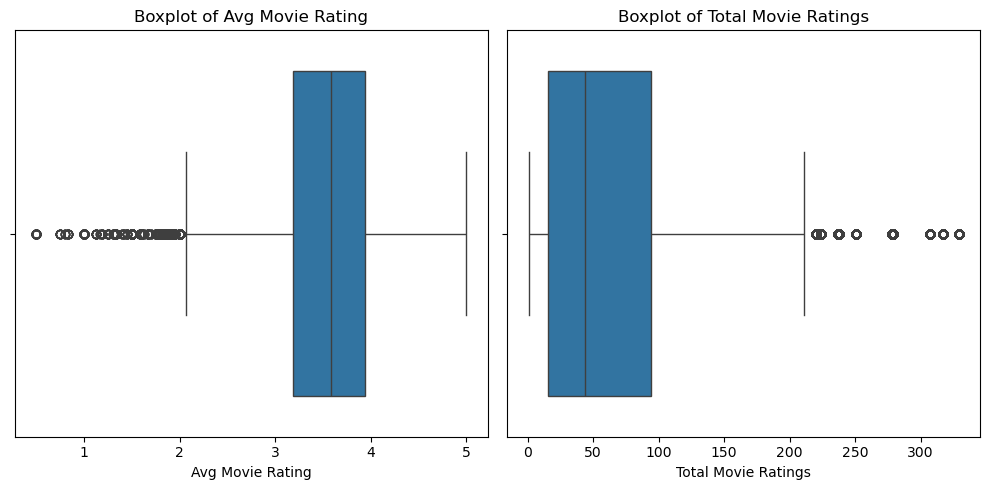

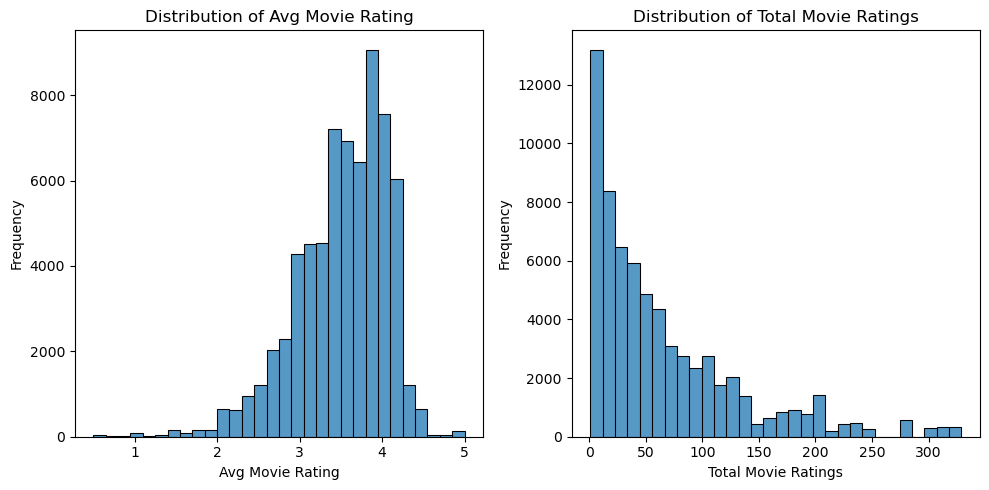

In [61]:
# Plot boxplots for average movie ratings and total movie ratings
plot_boxplots(df, ["avg_movie_rating", "total_movie_ratings"])

# Plot histograms for average movie ratings and total movie ratings
plot_histograms(df, ["avg_movie_rating", "total_movie_ratings"], bins=30)

Log-transforming average movie rating does not improve the distribution and instead creates more outliers. Therefore, we keep the average ratings per movie in the original form.

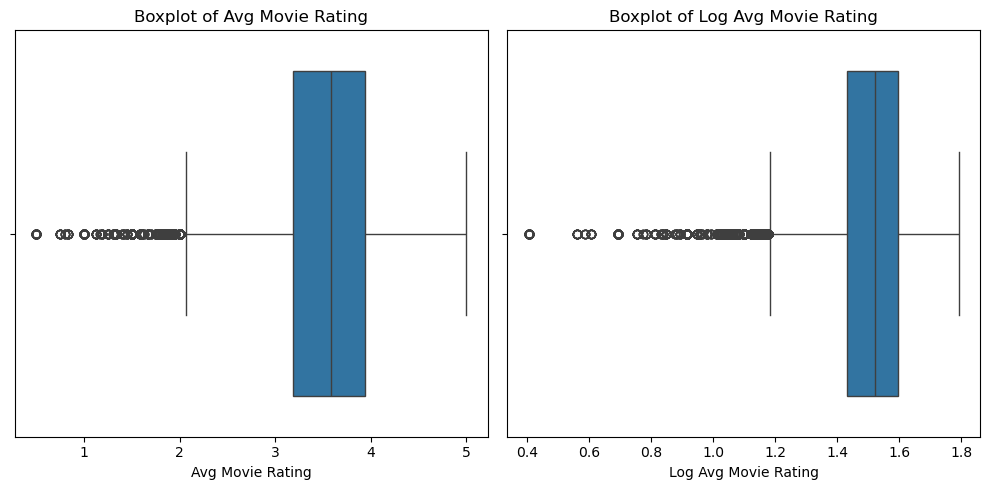

In [64]:
# Log transformation of average movie ratings
df["log_avg_movie_rating"] = np.log1p(df["avg_movie_rating"])

# Plot boxplots of original and log-transformed average movie ratings
plot_boxplots(df, ["avg_movie_rating", "log_avg_movie_rating"])

Log-transforming total movie ratings improves the distribution and removes outliers. Thus, this variable will be retained for the analysis.

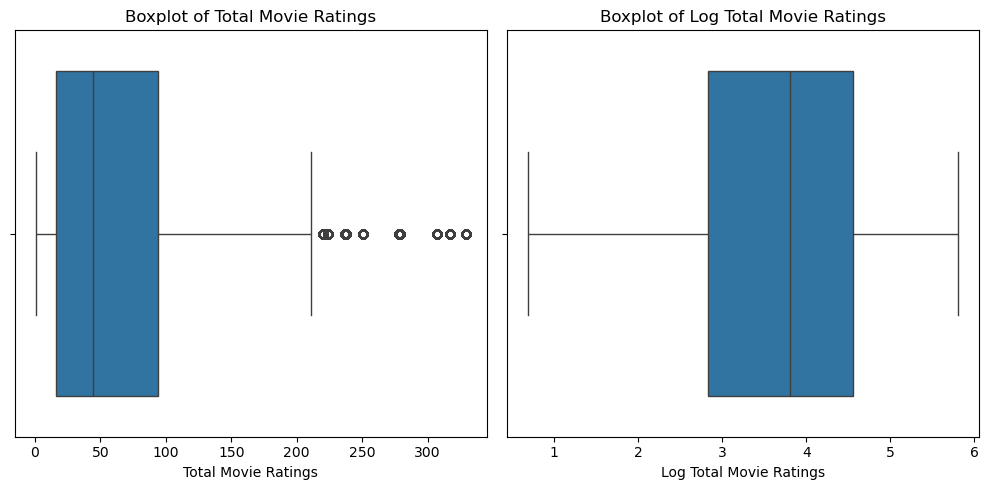

In [67]:
# Log transformation of total movie ratings
df["log_total_movie_ratings"] = np.log1p(df["total_movie_ratings"])

# Plot boxplots of original and log-transformed total movie ratings
plot_boxplots(df, ["total_movie_ratings", "log_total_movie_ratings"])

## 4.3 Time-based Features

Finally, we will create a few temporal features such as rating year, rating month, rating day of the week and years since release.

In [71]:
# Convert timestamp to datetime
df["timestamp"] = pd.to_datetime(df["timestamp"], unit="s")

# Extract year, month, and day of the week
df["rating_year"] = df["timestamp"].dt.year
df["rating_month"] = df["timestamp"].dt.month
df["rating_day_of_week"] = df["timestamp"].dt.dayofweek  # 0 = Monday, 6 = Sunday

#Compute time difference between rating and movie release
df["years_since_release"] = df["rating_year"] - df["release_year"]

# Display updated dataset preview
print("Temporal features added:")
df.head()

Temporal features added:


,userId,movieId,rating,timestamp,Action,Adventure,Animation,Children,Comedy,Crime,...,total_user_ratings,log_total_user_ratings,avg_movie_rating,total_movie_ratings,log_avg_movie_rating,log_total_movie_ratings,rating_year,rating_month,rating_day_of_week,years_since_release
1,0,2,4.0,2000-07-30 18:20:47,0.0,1.0,0.0,1.0,0.0,0.0,...,164,5.105945,3.259615,52,1.449179,3.970292,2000,7,6,5
2,0,5,4.0,2000-07-30 18:37:04,0.0,0.0,0.0,0.0,1.0,0.0,...,164,5.105945,3.946078,102,1.598595,4.634729,2000,7,6,5
3,0,43,5.0,2000-07-30 19:03:35,0.0,0.0,0.0,0.0,0.0,0.0,...,164,5.105945,3.975369,203,1.604500,5.318120,2000,7,6,5
4,0,46,5.0,2000-07-30 18:48:51,0.0,0.0,0.0,0.0,0.0,0.0,...,164,5.105945,4.237745,204,1.655891,5.323010,2000,7,6,5
5,0,62,3.0,2000-07-30 18:40:00,0.0,0.0,0.0,0.0,0.0,0.0,...,164,5.105945,3.509091,55,1.506096,4.025352,2000,7,6,5


Now we conduct some exploratory data analysis and handle outliers on these new features.

In [74]:
# Check for NaN values in new features
nan_counts = df[["rating_year", "rating_month", "rating_day_of_week", "release_year", "years_since_release"]].isnull().sum()
print("Missing values in new temporal features:")
print(nan_counts)

Missing values in new temporal features:
rating_year            0
rating_month           0
rating_day_of_week     0
release_year           0
years_since_release    0
dtype: int64


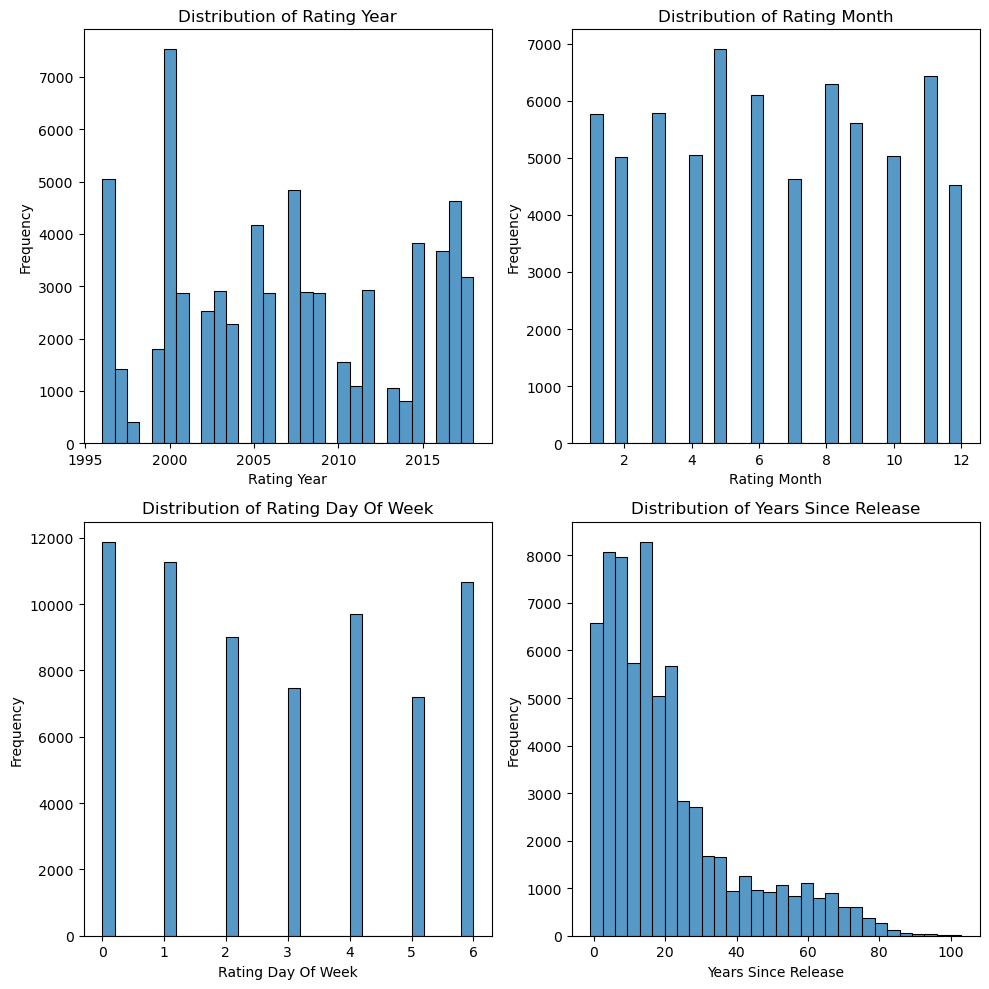

In [76]:
plot_histograms(df, ["rating_year", "rating_month", "rating_day_of_week", "years_since_release"], bins=30)

Since **years since release** is a highly skewed variable, we conduct a log transformation which removes the skewedness. The log-transformed version is then further used in creating models.

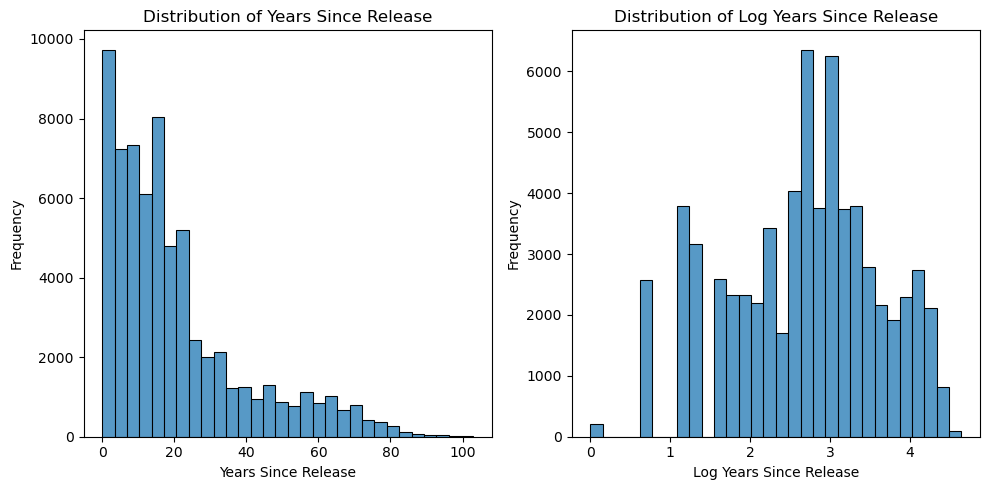

In [79]:
# Replacing negative values with NaN
df["years_since_release"] = df["years_since_release"].clip(lower=0)

# Log transform years since release
df["log_years_since_release"] = np.log1p(df["years_since_release"])

# Plot histograms
plot_histograms(df, ["years_since_release", "log_years_since_release"], bins=30)

# 5 Preparing Dataset for Training

## 5.1 Feature Selection

Before proceeding with feature selection, we look at a correlation plot for all the numerical features to determine how each variable is associated with the prediction variable (ratings).

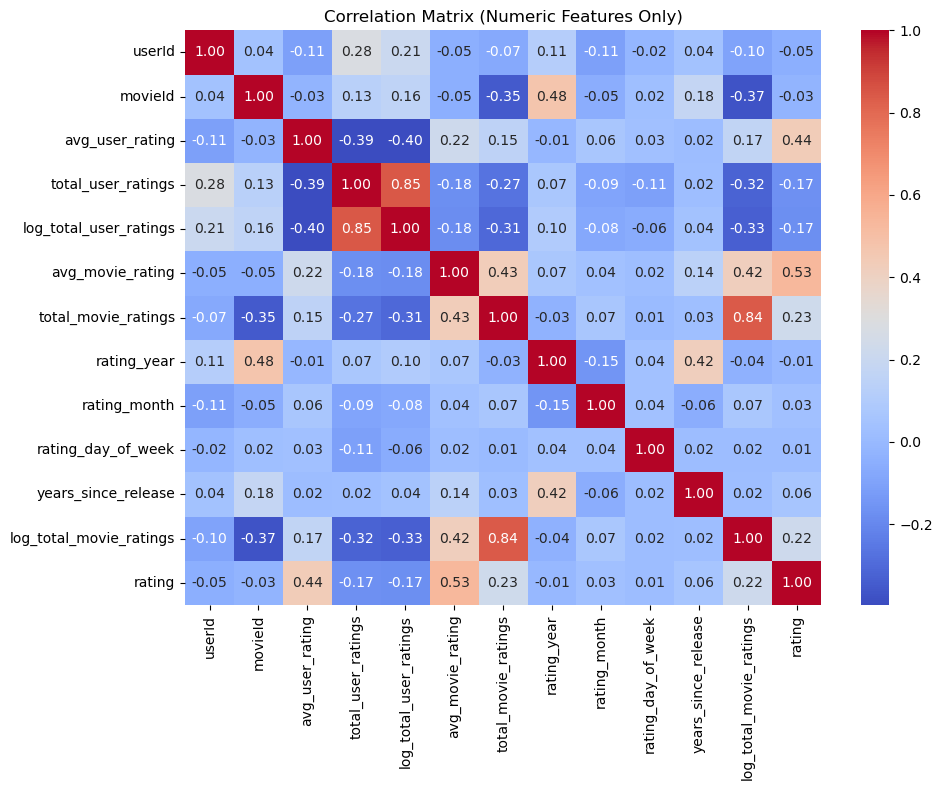

In [84]:
# Define numeric features only (excluding genres)
numeric_features = [
    "userId", "movieId", "avg_user_rating", "total_user_ratings",
    "log_total_user_ratings", "avg_movie_rating", "total_movie_ratings",
    "rating_year", "rating_month", "rating_day_of_week", "years_since_release",
    "log_total_movie_ratings", "rating"
]

# Compute and plot correlation matrix for numeric features
plt.figure(figsize=(10, 8))
sns.heatmap(df[numeric_features].corr(), annot=True, cmap="coolwarm", fmt=".2f", cbar=True)
plt.title("Correlation Matrix (Numeric Features Only)")
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

Now, we select the relevant variables we would like to use in our analysis. This includes several numerical variables (both from the original dataset and feature engineering) along with dummy variables for genres which had p-values less than 0.05 during the ANOVA analysis in section 3.

In [87]:
# Define the columns you want to keep
selected_features = [
    "userId", "movieId", "avg_user_rating", "log_total_user_ratings", 
    "avg_movie_rating", "log_total_movie_ratings", "rating_year", 
    "rating_month", "rating_day_of_week", "log_years_since_release", 
    "Comedy", "Sci-Fi", "Mystery", "Drama", "Thriller", "Romance",
    "Musical", "Horror", "IMAX", "Animation", "Action", "Children", 
    "Fantasy", "Film-Noir", "rating"
]

# Select these columns from the dataset
df_final = df[selected_features].copy()

# Print the first few rows to confirm
print("Selected features:")
df_final.head()

Selected features:


,userId,movieId,avg_user_rating,log_total_user_ratings,avg_movie_rating,log_total_movie_ratings,rating_year,rating_month,rating_day_of_week,log_years_since_release,...,Romance,Musical,Horror,IMAX,Animation,Action,Children,Fantasy,Film-Noir,rating
1,0,2,4.365854,5.105945,3.259615,3.970292,2000,7,6,1.791759,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,4.0
2,0,5,4.365854,5.105945,3.946078,4.634729,2000,7,6,1.791759,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0
3,0,43,4.365854,5.105945,3.975369,5.318120,2000,7,6,1.791759,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0
4,0,46,4.365854,5.105945,4.237745,5.323010,2000,7,6,1.791759,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0
5,0,62,4.365854,5.105945,3.509091,4.025352,2000,7,6,1.791759,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0


## 5.2 Feature Scaling

It is important to scale the numerical variables because it ensures that all features contribute equally to model, preventing variables with larger magnitudes from dominating those with smaller values.

In [91]:
# Scale numerical features to range (0,1)
scaler = MinMaxScaler(feature_range=(0, 1))
features_to_scale = ["avg_user_rating", "avg_movie_rating", "log_total_user_ratings", "log_total_movie_ratings", "log_years_since_release"]

df_final[features_to_scale] = scaler.fit_transform(df[features_to_scale])

# Creating a normalised rating column
df_final["normalised_rating"] = scaler.fit_transform(df_final[["rating"]])

# Display updated dataset preview
print("Scaled numerical features:")
df_final[features_to_scale].head()

Scaled numerical features:


,avg_user_rating,avg_movie_rating,log_total_user_ratings,log_total_movie_ratings,log_years_since_release
1,0.830894,0.613248,0.551209,0.641829,0.38579
2,0.830894,0.765795,0.551209,0.771959,0.38579
3,0.830894,0.772304,0.551209,0.905801,0.38579
4,0.830894,0.830610,0.551209,0.906759,0.38579
5,0.830894,0.668687,0.551209,0.652613,0.38579


In [93]:
df_final.info()

<class 'pandas.core.frame.DataFrame'>
Index: 67160 entries, 1 to 100783
Data columns (total 26 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   userId                   67160 non-null  int64  
 1   movieId                  67160 non-null  int64  
 2   avg_user_rating          67160 non-null  float64
 3   log_total_user_ratings   67160 non-null  float64
 4   avg_movie_rating         67160 non-null  float64
 5   log_total_movie_ratings  67160 non-null  float64
 6   rating_year              67160 non-null  int32  
 7   rating_month             67160 non-null  int32  
 8   rating_day_of_week       67160 non-null  int32  
 9   log_years_since_release  67160 non-null  float64
 10  Comedy                   67160 non-null  float64
 11  Sci-Fi                   67160 non-null  float64
 12  Mystery                  67160 non-null  float64
 13  Drama                    67160 non-null  float64
 14  Thriller                 6

## 5.3 Splitting the Dataset

We now split the dataset into training, validation and test sets. This split is done on a 60-20-20 basis.

In [126]:
# Define the feature columns (X) and the target column (y)
# We assume the dataset has a column "normalised_rating" as the target and all other numerical columns as features.
X = df_final.drop(columns=["normalised_rating", "rating"])  # Features
y = df_final["normalised_rating"]  # Target

# Split the data into train, validation, and test sets
# First, split into training+validation and test
X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Next, split the training+validation set into train and validation
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.25, random_state=42)

# This results in:
# 60% training, 20% validation, 20% test (approximately)

# Print dataset sizes to verify the splits
print("Training set size:", X_train.shape[0])
print("Validation set size:", X_val.shape[0])
print("Test set size:", X_test.shape[0])

Training set size: 40296
Validation set size: 13432
Test set size: 13432


# 6 Training Models

In this section, we will begin training our prediction models. We will first explore traditional machine learning models and then move on to neural networks.

## 6.1 Traditional Machine Learning Models
Here, we generate linear regression, random forest and XGBoost models to predict movie ratings.

In [128]:
def save_traditional_model(model, model_name, save_path="./Save_Models/"):
    """
    Saves a single model to the specified directory using joblib.

    Parameters:
    model (object): The trained model to be saved.
    model_name (str): Name to save the model file as (without extension).
    save_path (str): Path to the directory where the model will be saved. Default is './Save_Models/'.

    Returns:
    None (Saves the model as a .joblib file)
    """

    # Ensure the save directory exists
    os.makedirs(save_path, exist_ok=True)  # Creates directory if it doesn't exist

    # Define the full path for saving
    file_path = os.path.join(save_path, f"{model_name}.joblib")

    # Save the model
    joblib.dump(model, file_path)

    # Print confirmation message
    print(f"Model '{model_name}' saved at: {file_path}")

### 6.1.1 Linear Regression

In [130]:
lr_model = LinearRegression()
lr_model.fit(X_train, y_train)

LinearRegression()

In [132]:
save_traditional_model(lr_model, "lr_model")

Model 'lr_model' saved at: ./Save_Models/lr_model.joblib


### 6.1.2 Random Forest

In [135]:
rf_model = RandomForestRegressor(n_estimators=100, max_depth=10, random_state=42)
rf_model.fit(X_train, y_train)

RandomForestRegressor(max_depth=10, random_state=42)

In [136]:
save_traditional_model(rf_model, "rf_model")

Model 'rf_model' saved at: ./Save_Models/rf_model.joblib


### 6.1.3 XGBoost

In [145]:
xgb_model = XGBRegressor(n_estimators=100, max_depth=6, learning_rate=0.1, random_state=42)
xgb_model.fit(X_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.1, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=6, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, random_state=42, ...)

In [147]:
save_traditional_model(xgb_model, "xgb_model")

Model 'xgb_model' saved at: ./Save_Models/xgb_model.joblib


## 6.2 Neural Networks

In [149]:
def save_model_and_history(model, history, model_number, save_path="./Save_Models/"):
    """
    Saves a trained neural network model and its training history.

    Parameters:
    model (tf.keras.Model): The trained neural network model.
    history (tf.keras.callbacks.History): The training history of the model.
    model_number (int): The model number for naming files uniquely.
    save_path (str): The directory where models and history files will be saved.

    Returns:
    None (Saves model and history)
    """
    
    # Ensure save directory exists
    os.makedirs(save_path, exist_ok=True)

    # Define model and history file names
    model_filename = f"model{model_number}.keras"
    history_filename = f"model{model_number}_history.pkl"

    # Save the trained model
    model.save(os.path.join(save_path, model_filename))
    print(f"Model {model_number} saved at: {os.path.join(save_path, model_filename)}")

    # Save training history using pickle
    history_path = os.path.join(save_path, history_filename)
    with open(history_path, "wb") as file:
        pickle.dump(history.history, file)
    print(f"Training history for Model {model_number} saved at: {history_path}")

In [151]:
# Calculate number of unique users
num_users = df_final["userId"].nunique()

# Calculate number of unique movies
num_movies = df_final["movieId"].max() + 1 # Recalculate num_movies to include the maximum movie ID

# Determine number of other numerical features (for dense layers)
num_other_features = X_train.drop(columns=["userId", "movieId"]).shape[1]

In [239]:
print(num_users)
print(num_movies)
print(num_other_features)

610
9019
22


### 6.2.1 Model 1

Before defining the model, it is important to define the neural network architecture. The input architecture is structured using the following:
* **Embeddings** help capture latent relationships between users and movies instead of treating them like arbitrary IDs
* **Other features** such as rating history provide extra context for better predictions
* **Concatenation** merges all inputs, allowing the network to learn from both categorical and numerical data.

In [153]:
# Define the neural network architecture
# User ID input and embedding
user_input = Input(shape=(1,), name="user_id_input")
user_embedding = Embedding(input_dim=num_users, output_dim=50)(user_input)
user_embedding_flat = Flatten()(user_embedding)

# Movie ID input and embedding
movie_input = Input(shape=(1,), name="movie_id_input")
movie_embedding = Embedding(input_dim=num_movies, output_dim=50)(movie_input)
movie_embedding_flat = Flatten()(movie_embedding)

# Other features input
other_features_input = Input(shape=(num_other_features,), name="other_features_input")

# Concatenate all inputs
concatenated = Concatenate()([user_embedding_flat, movie_embedding_flat, other_features_input])

# Dense layers for prediction
x = Dense(128, activation="relu")(concatenated)
x = Dense(64, activation="relu")(x)
output = Dense(1, activation="sigmoid", name="normalized_rating_output")(x)

# Compile the model
model1 = Model(inputs=[user_input, movie_input, other_features_input], outputs=output)
model1.compile(optimizer="adam", loss="mse", metrics=["mae"])

# Train the model
history1 = model1.fit(
    [X_train["userId"], X_train["movieId"], X_train.drop(columns=["userId", "movieId"])],
    y_train,
    validation_data=([X_val["userId"], X_val["movieId"], X_val.drop(columns=["userId", "movieId"])], y_val),
    epochs=10,
    batch_size=32,
    shuffle=False
)

# Print validation loss and mean absolute error
print("Validation loss (MSE):", history1.history['val_loss'][-1])
print("Validation MAE:", history1.history['val_mae'][-1])

Epoch 1/10
1260/1260 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - loss: 0.1623 - mae: 0.3300 - val_loss: 0.1612 - val_mae: 0.3283
Epoch 2/10
1260/1260 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.1628 - mae: 0.3306 - val_loss: 0.1612 - val_mae: 0.3283
Epoch 3/10
1260/1260 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.1628 - mae: 0.3306 - val_loss: 0.1612 - val_mae: 0.3283
Epoch 4/10
1260/1260 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.1628 - mae: 0.3306 - val_loss: 0.1612 - val_mae: 0.3283
Epoch 5/10
1260/1260 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.1628 - mae: 0.3306 - val_loss: 0.1612 - val_mae: 0.3283
Epoch 6/10
1260/1260 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.1628 - mae: 0.3306 - val_loss: 0.1612 - val_mae: 0.3283
Epoch 7/10
1260/1260 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 0.1628 - mae: 0.3306 - val_loss: 0.1612 - val_mae: 0.3283
Epoch 8/10
1260/1260 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 0.1628 - mae: 0.3306 - val_loss: 0.1612 - val_mae: 0.3283
Epoch 9/10
1260/1260 ━━━━━━━━━━━━━━━━━━━

In [155]:
save_model_and_history(model1, history1, 1)

Model 1 saved at: ./Save_Models/model1.keras
Training history for Model 1 saved at: ./Save_Models/model1_history.pkl


### 6.2.2 Model 2

In [157]:
# Define the neural network architecture with improvements
# User ID input and embedding (increased embedding size)
user_input = Input(shape=(1,), name="user_id_input")
user_embedding = Embedding(input_dim=num_users, output_dim=128)(user_input)  # Increased embedding size
user_embedding_flat = Flatten()(user_embedding)

# Movie ID input and embedding
movie_input = Input(shape=(1,), name="movie_id_input")
movie_embedding = Embedding(input_dim=num_movies, output_dim=128)(movie_input)  # Increased embedding size
movie_embedding_flat = Flatten()(movie_embedding)

# Other features input
other_features_input = Input(shape=(num_other_features,), name="other_features_input")

# Concatenate all inputs
concatenated = Concatenate()([user_embedding_flat, movie_embedding_flat, other_features_input])

# Dense layers for prediction with Batch Normalization and Dropout
x = Dense(256, activation="relu")(concatenated)
x = BatchNormalization()(x)  # Normalize activations for stable training
x = Dropout(0.3)(x)  # Prevent overfitting

x = Dense(128, activation="relu")(x)
x = BatchNormalization()(x)
x = Dropout(0.3)(x)

x = Dense(64, activation="relu")(x)
x = BatchNormalization()(x)
x = Dropout(0.3)(x)

# Output layer for rating prediction
output = Dense(1, activation="sigmoid", name="normalized_rating_output")(x)

# Compile the model with a lower learning rate
model2 = Model(inputs=[user_input, movie_input, other_features_input], outputs=output)
model2.compile(optimizer=Adam(learning_rate=0.0005), loss="mse", metrics=["mae"])  # Adjusted learning rate

# Train the model
history2 = model2.fit(
    [X_train["userId"], X_train["movieId"], X_train.drop(columns=["userId", "movieId"])],
    y_train,
    validation_data=([X_val["userId"], X_val["movieId"], X_val.drop(columns=["userId", "movieId"])], y_val),
    epochs=10,  
    batch_size=64,  # Increased batch size for stability
    shuffle=False  
)

# Evaluate on the validation set
val_results2 = model2.evaluate(
    [X_val["userId"], X_val["movieId"], X_val.drop(columns=["userId", "movieId"])],
    y_val
)

print("Validation loss (MSE):", val_results2[0])
print("Validation MAE:", val_results2[1])

Epoch 1/10
630/630 ━━━━━━━━━━━━━━━━━━━━ 6s 5ms/step - loss: 0.0928 - mae: 0.2417 - val_loss: 0.5046 - val_mae: 0.6717
Epoch 2/10
630/630 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 0.0441 - mae: 0.1637 - val_loss: 0.5031 - val_mae: 0.6707
Epoch 3/10
630/630 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 0.0374 - mae: 0.1502 - val_loss: 0.1220 - val_mae: 0.2850
Epoch 4/10
630/630 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 0.0351 - mae: 0.1448 - val_loss: 0.3246 - val_mae: 0.5355
Epoch 5/10
630/630 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 0.0341 - mae: 0.1421 - val_loss: 0.4400 - val_mae: 0.6265
Epoch 6/10
630/630 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 0.0328 - mae: 0.1397 - val_loss: 0.5030 - val_mae: 0.6706
Epoch 7/10
630/630 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 0.0327 - mae: 0.1390 - val_loss: 0.2730 - val_mae: 0.4866
Epoch 8/10
630/630 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 0.0318 - mae: 0.1365 - val_loss: 0.4638 - val_mae: 0.6446
Epoch 9/10
630/630 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - lo

In [159]:
save_model_and_history(model2, history2, 2)

Model 2 saved at: ./Save_Models/model2.keras
Training history for Model 2 saved at: ./Save_Models/model2_history.pkl


### 6.2.3 Model 3

In [161]:
# Define the neural network architecture with improvements
# User ID input and embedding (simplified embedding size)
user_input = Input(shape=(1,), name="user_id_input")
user_embedding = Embedding(input_dim=num_users, output_dim=64)(user_input)  
user_embedding_flat = Flatten()(user_embedding)

# Movie ID input and embedding
movie_input = Input(shape=(1,), name="movie_id_input")
movie_embedding = Embedding(input_dim=num_movies, output_dim=64)(movie_input)  
movie_embedding_flat = Flatten()(movie_embedding)

# Other features input
other_features_input = Input(shape=(num_other_features,), name="other_features_input")

# Concatenate all inputs
concatenated = Concatenate()([user_embedding_flat, movie_embedding_flat, other_features_input])

# Dense layers for prediction with L2 regularization & lower dropout
x = Dense(128, activation="relu", kernel_regularizer=l2(0.001))(concatenated)  # L2 Regularization
x = BatchNormalization()(x)
x = Dropout(0.2)(x)  

x = Dense(64, activation="relu", kernel_regularizer=l2(0.001))(x)
x = BatchNormalization()(x)
x = Dropout(0.2)(x)

output = Dense(1, activation="sigmoid", name="normalized_rating_output")(x)

# Compile the model with a slightly higher learning rate
model3 = Model(inputs=[user_input, movie_input, other_features_input], outputs=output)
model3.compile(optimizer=Adam(learning_rate=0.001), loss="mse", metrics=["mae"])  

# Train the model
history3 = model3.fit(
    [X_train["userId"], X_train["movieId"], X_train.drop(columns=["userId", "movieId"])],
    y_train,
    validation_data=([X_val["userId"], X_val["movieId"], X_val.drop(columns=["userId", "movieId"])], y_val),
    epochs=10,  
    batch_size=64,  # Keep batch size stable
    shuffle=False
)

# Evaluate on the validation set
val_results3 = model3.evaluate(
    [X_val["userId"], X_val["movieId"], X_val.drop(columns=["userId", "movieId"])],
    y_val
)

print("Validation loss (MSE):", val_results3[0])
print("Validation MAE:", val_results3[1])

Epoch 1/10
630/630 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - loss: 0.1575 - mae: 0.2110 - val_loss: 0.4723 - val_mae: 0.6374
Epoch 2/10
630/630 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.0518 - mae: 0.1508 - val_loss: 0.1682 - val_mae: 0.3283
Epoch 3/10
630/630 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.0388 - mae: 0.1403 - val_loss: 0.1651 - val_mae: 0.3283
Epoch 4/10
630/630 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.0336 - mae: 0.1333 - val_loss: 0.1643 - val_mae: 0.3283
Epoch 5/10
630/630 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.0313 - mae: 0.1300 - val_loss: 0.4337 - val_mae: 0.6208
Epoch 6/10
630/630 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.0299 - mae: 0.1272 - val_loss: 0.5065 - val_mae: 0.6717
Epoch 7/10
630/630 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.0302 - mae: 0.1293 - val_loss: 0.3267 - val_mae: 0.5328
Epoch 8/10
630/630 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.0350 - mae: 0.1405 - val_loss: 0.4950 - val_mae: 0.6644
Epoch 9/10
630/630 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - lo

In [163]:
save_model_and_history(model3, history3, 3)

Model 3 saved at: ./Save_Models/model3.keras
Training history for Model 3 saved at: ./Save_Models/model3_history.pkl


### 6.2.4 Model 4

In [165]:
# Define the neural network architecture with improvements
# User ID input and embedding (reduced embedding size)
user_input = Input(shape=(1,), name="user_id_input")
user_embedding = Embedding(input_dim=num_users, output_dim=32)(user_input)  # Reduced embedding size
user_embedding_flat = Flatten()(user_embedding)

# Movie ID input and embedding
movie_input = Input(shape=(1,), name="movie_id_input")
movie_embedding = Embedding(input_dim=num_movies, output_dim=32)(movie_input)  # Reduced embedding size
movie_embedding_flat = Flatten()(movie_embedding)

# Other features input
other_features_input = Input(shape=(num_other_features,), name="other_features_input")

# Concatenate all inputs
concatenated = Concatenate()([user_embedding_flat, movie_embedding_flat, other_features_input])

# Dense layers for prediction with L2 regularization & lower dropout
x = Dense(128, activation="relu", kernel_regularizer=l2(0.0005))(concatenated)
x = BatchNormalization()(x)
x = Dropout(0.1)(x)  # Reduced dropout

x = Dense(64, activation="relu", kernel_regularizer=l2(0.0005))(x)
x = BatchNormalization()(x)
x = Dropout(0.1)(x)

output = Dense(1, activation="sigmoid", name="normalized_rating_output")(x)

# Compile the model with lower learning rate and gradient clipping
optimizer = Adam(learning_rate=0.0001, clipnorm=1.0)  # Lower learning rate + gradient clipping
model4 = Model(inputs=[user_input, movie_input, other_features_input], outputs=output)
model4.compile(optimizer=optimizer, loss="mse", metrics=["mae"])

# Implement Early Stopping
early_stopping = EarlyStopping(monitor="val_loss", patience=3, restore_best_weights=True)

# Train the model
history4 = model4.fit(
    [X_train["userId"], X_train["movieId"], X_train.drop(columns=["userId", "movieId"])],
    y_train,
    validation_data=([X_val["userId"], X_val["movieId"], X_val.drop(columns=["userId", "movieId"])], y_val),
    epochs=30,  # More epochs, but stops early if needed
    batch_size=64,  # Keep batch size stable
    shuffle=False,
    callbacks=[early_stopping]  # Stops training if no improvement
)

# Evaluate on the validation set
val_results4 = model4.evaluate(
    [X_val["userId"], X_val["movieId"], X_val.drop(columns=["userId", "movieId"])],
    y_val
)

print("Validation loss (MSE):", val_results4[0])
print("Validation MAE:", val_results4[1])

Epoch 1/30
630/630 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - loss: 0.1796 - mae: 0.2556 - val_loss: 0.5522 - val_mae: 0.6707
Epoch 2/30
630/630 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.1018 - mae: 0.1922 - val_loss: 0.5357 - val_mae: 0.6716
Epoch 3/30
630/630 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.0768 - mae: 0.1712 - val_loss: 0.5286 - val_mae: 0.6717
Epoch 4/30
630/630 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.0661 - mae: 0.1611 - val_loss: 0.5253 - val_mae: 0.6717
Epoch 5/30
630/630 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.0615 - mae: 0.1577 - val_loss: 0.4056 - val_mae: 0.5854
Epoch 6/30
630/630 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.0584 - mae: 0.1558 - val_loss: 0.4167 - val_mae: 0.5968
Epoch 7/30
630/630 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.0551 - mae: 0.1522 - val_loss: 0.4280 - val_mae: 0.6062
Epoch 8/30
630/630 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.0524 - mae: 0.1492 - val_loss: 0.5145 - val_mae: 0.6690
420/420 ━━━━━━━━━━━━━━━━━━━━ 0s 916us/step - loss: 0.403

In [241]:
save_model_and_history(model4, history4, 4)

Model 4 saved at: ./Save_Models/model4.keras
Training history for Model 4 saved at: ./Save_Models/model4_history.pkl


### 6.2.5 Model 5

In [171]:
# Define Exponential Decay Learning Rate
def exponential_decay(epoch, lr):
    decay_rate = 0.96  # Slower decay
    decay_step = 3
    return lr * (decay_rate ** (epoch / decay_step))

# Define the improved neural network architecture
user_input = Input(shape=(1,), name="user_id_input")
user_embedding = Embedding(input_dim=num_users, output_dim=50)(user_input)  # Increased embedding size
user_embedding_flat = Flatten()(user_embedding)

movie_input = Input(shape=(1,), name="movie_id_input")
movie_embedding = Embedding(input_dim=num_movies, output_dim=50)(movie_input)  # Increased embedding size
movie_embedding_flat = Flatten()(movie_embedding)

other_features_input = Input(shape=(num_other_features,), name="other_features_input")
concatenated = Concatenate()([user_embedding_flat, movie_embedding_flat, other_features_input])

# Dense layers with stability improvements
x = Dense(128, kernel_regularizer=l2(0.0003))(concatenated)
x = BatchNormalization(momentum=0.85)(x)
x = Activation(swish)(x)
x = Dropout(0.2)(x)  

x = Dense(64, kernel_regularizer=l2(0.0003))(x)
x = BatchNormalization(momentum=0.85)(x)
x = Activation(swish)(x)
x = Dropout(0.2)(x)

x = Dense(32, kernel_regularizer=l2(0.0003))(x)
x = BatchNormalization(momentum=0.85)(x)
x = Activation(swish)(x)
x = Dropout(0.2)(x)  

x = Dense(16, kernel_regularizer=l2(0.0003))(x)  # Additional final layer
x = BatchNormalization(momentum=0.85)(x)
x = Activation(swish)(x)

output = Dense(1, activation="sigmoid", name="normalized_rating_output")(x)

# Compile the model with Exponential Decay Learning Rate
optimizer = Adam(learning_rate=0.0001, clipnorm=1.0)
model5 = Model(inputs=[user_input, movie_input, other_features_input], outputs=output)
model5.compile(optimizer=optimizer, loss="mse", metrics=["mae"])

# Use Early Stopping and Exponential Decay Scheduler
early_stopping = EarlyStopping(monitor="val_loss", patience=5, restore_best_weights=True)
lr_scheduler = LearningRateScheduler(exponential_decay)

# Train the improved model
history5= model5.fit(
    [X_train["userId"], X_train["movieId"], X_train.drop(columns=["userId", "movieId"])],
    y_train,
    validation_data=([X_val["userId"], X_val["movieId"], X_val.drop(columns=["userId", "movieId"])], y_val),
    epochs=30,  # Increased for fine-tuning
    batch_size=64,  # Balanced batch size
    shuffle=False,
    callbacks=[early_stopping, lr_scheduler]
)

# Evaluate on the validation set
val_results5 = model5.evaluate(
    [X_val["userId"], X_val["movieId"], X_val.drop(columns=["userId", "movieId"])],
    y_val
)

print("Final Validation loss (MSE):", val_results5[0])
print("Final Validation MAE:", val_results5[1])

Epoch 1/30
630/630 ━━━━━━━━━━━━━━━━━━━━ 7s 6ms/step - loss: 0.1898 - mae: 0.2825 - val_loss: 0.1270 - val_mae: 0.2114 - learning_rate: 1.0000e-04
Epoch 2/30
630/630 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 0.1275 - mae: 0.2177 - val_loss: 0.1153 - val_mae: 0.2140 - learning_rate: 9.8648e-05
Epoch 3/30
630/630 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 0.0995 - mae: 0.1848 - val_loss: 0.0865 - val_mae: 0.1667 - learning_rate: 9.6000e-05
Epoch 4/30
630/630 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - loss: 0.0836 - mae: 0.1635 - val_loss: 0.1028 - val_mae: 0.1968 - learning_rate: 9.2160e-05
Epoch 5/30
630/630 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - loss: 0.0749 - mae: 0.1535 - val_loss: 0.1270 - val_mae: 0.2425 - learning_rate: 8.7278e-05
Epoch 6/30
630/630 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - loss: 0.0694 - mae: 0.1490 - val_loss: 0.1274 - val_mae: 0.2492 - learning_rate: 8.1537e-05
Epoch 7/30
630/630 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 0.0648 - mae: 0.1456 - val_loss: 0.1115 - val_mae: 0.2299 - lear

In [173]:
save_model_and_history(model5, history5, 5)

Model 5 saved at: ./Save_Models/model5.keras
Training history for Model 5 saved at: ./Save_Models/model5_history.pkl


# 7 Fine Tuning Models

In [109]:
# Convert errors back to original scale
def denormalize_error(normalized_value):
    return normalized_value * (5.0 - 0.5)

## 7.1 Random Forest Grid Search

In [175]:
# Grid Search for Random Forest
param_grid_rf = {
    "n_estimators": [50, 100, 200],
    "max_depth": [None, 10, 20],
    "min_samples_split": [2, 5, 10]
}

rf_grid = HalvingGridSearchCV(RandomForestRegressor(random_state=42), param_grid_rf, cv=3, scoring="neg_mean_squared_error", n_jobs=2, verbose=1)
rf_grid.fit(X_train, y_train)
best_rf = rf_grid.best_estimator_
print("Best Parameters for Random Forest:", rf_grid.best_params_)

n_iterations: 4
n_required_iterations: 4
n_possible_iterations: 4
min_resources_: 1492
max_resources_: 40296
aggressive_elimination: False
factor: 3
----------
iter: 0
n_candidates: 27
n_resources: 1492
Fitting 3 folds for each of 27 candidates, totalling 81 fits
----------
iter: 1
n_candidates: 9
n_resources: 4476
Fitting 3 folds for each of 9 candidates, totalling 27 fits
----------
iter: 2
n_candidates: 3
n_resources: 13428
Fitting 3 folds for each of 3 candidates, totalling 9 fits
----------
iter: 3
n_candidates: 1
n_resources: 40284
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Best Parameters for Random Forest: {'max_depth': 10, 'min_samples_split': 10, 'n_estimators': 200}


The Random Forest Grid Search suggests the following hyperparameters for optimal results in predicting movie ratings:

```
1. max_depth = 10
2. min_samples_split = 10
3. n_estimators = 200
```
These values are used in an optimized random forest model as shown below.

In [178]:
# Define the Best Random Forest Model with Optimal Parameters
optimized_rf = RandomForestRegressor(
    max_depth=10,
    min_samples_split=10,
    n_estimators=200,
    random_state=42,
    n_jobs=-1
)

# Train the Optimized Model
optimized_rf.fit(X_train, y_train)

# Generate Predictions on Validation Set
rf_val_predictions = optimized_rf.predict(X_val)

# Compute Validation MSE and MAE
rf_val_mse = mean_squared_error(y_val, rf_val_predictions)
rf_val_mae = mean_absolute_error(y_val, rf_val_predictions)

In [180]:
save_traditional_model(optimized_rf, "optimized_rf")

Model 'optimized_rf' saved at: ./Save_Models/optimized_rf.joblib


## 7.2 XGBoost Grid Search

In [182]:
# Grid Search for XGBoost
param_grid_xgb = {
    "n_estimators": [50, 100, 200],
    "max_depth": [3, 6, 10],
    "learning_rate": [0.01, 0.1, 0.2]
}

xgb_grid = HalvingGridSearchCV(XGBRegressor(random_state=42), param_grid_xgb, cv=3, scoring="neg_mean_squared_error", n_jobs=2, verbose=1)
xgb_grid.fit(X_train, y_train)
best_xgb = xgb_grid.best_estimator_
print("Best Parameters for XGBoost:", xgb_grid.best_params_)

n_iterations: 4
n_required_iterations: 4
n_possible_iterations: 4
min_resources_: 1492
max_resources_: 40296
aggressive_elimination: False
factor: 3
----------
iter: 0
n_candidates: 27
n_resources: 1492
Fitting 3 folds for each of 27 candidates, totalling 81 fits
----------
iter: 1
n_candidates: 9
n_resources: 4476
Fitting 3 folds for each of 9 candidates, totalling 27 fits
----------
iter: 2
n_candidates: 3
n_resources: 13428
Fitting 3 folds for each of 3 candidates, totalling 9 fits
----------
iter: 3
n_candidates: 1
n_resources: 40284
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Best Parameters for XGBoost: {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 100}


The XGBoost Grid Search suggests the following hyperparameters for optimal results in predicting movie ratings:

```
1. learning_rate = 0.1
2. max_depth = 3
3. n_estimators = 100
```
These values are used in an optimized XGBoost model as shown below.

In [185]:
# Define the Best XGBoost Model with Optimal Parameters
optimized_xgb = XGBRegressor(
    learning_rate=0.1,
    max_depth=3,
    n_estimators=100,
    random_state=42,
    n_jobs=-1
)

# Train the Optimized Model
optimized_xgb.fit(X_train, y_train)

#Generate Predictions on Validation Set
optimized_xgb_val_predictions = optimized_xgb.predict(X_val)

#Compute Validation MSE and MAE
optimized_xgb_val_mse = mean_squared_error(y_val, optimized_xgb_val_predictions)
optimized_xgb_val_mae = mean_absolute_error(y_val, optimized_xgb_val_predictions)

In [187]:
save_traditional_model(optimized_xgb, "optimized_xgb")

Model 'optimized_xgb' saved at: ./Save_Models/optimized_xgb.joblib


## 7.3 Neural Networks Random Search

In [191]:
import stat

# Function to force delete locked files
def force_remove_readonly(func, path, _):
    """ Handle readonly file deletion on Windows """
    os.chmod(path, stat.S_IWRITE)
    func(path)

# DELETE OLD TUNER FILES TO FORCE FRESH SEARCH
tuner_directory = "tuning"
if os.path.exists(tuner_directory):
    shutil.rmtree(tuner_directory, onerror=force_remove_readonly)  # Force delete locked files

print("Deleted old tuning session. Starting fresh search.")

Deleted old tuning session. Starting fresh search.


In [193]:
# Grid Search for Model 5 (Neural Network)
def build_nn_model(hp):
    """ Function to create a tunable Keras model """
    user_input = Input(shape=(1,), name="user_id_input")
    user_embedding = Embedding(input_dim=num_users, output_dim=hp.Choice("embedding_size", [16, 32, 64]))(user_input)
    user_embedding_flat = Flatten()(user_embedding)

    movie_input = Input(shape=(1,), name="movie_id_input")
    movie_embedding = Embedding(input_dim=num_movies, output_dim=hp.Choice("embedding_size", [16, 32, 64]))(movie_input)
    movie_embedding_flat = Flatten()(movie_embedding)

    other_features_input = Input(shape=(num_other_features,), name="other_features_input")
    concatenated = Concatenate()([user_embedding_flat, movie_embedding_flat, other_features_input])

    x = Dense(hp.Int("units_1", min_value=64, max_value=256, step=64), activation="relu")(concatenated)
    x = BatchNormalization()(x)
    x = Dropout(hp.Float("dropout_1", 0.1, 0.5, step=0.1))(x)

    x = Dense(hp.Int("units_2", min_value=32, max_value=128, step=32), activation="relu")(x)
    x = BatchNormalization()(x)
    x = Dropout(hp.Float("dropout_2", 0.1, 0.5, step=0.1))(x)

    output = Dense(1, activation="sigmoid", name="normalized_rating_output")(x)

    model = Model(inputs=[user_input, movie_input, other_features_input], outputs=output)
    model.compile(optimizer=Adam(learning_rate=hp.Choice("learning_rate", [0.0001, 0.0005, 0.001])),
                  loss="mse", metrics=["mae"])
    return model

# Define Keras Tuner for Model 5
tuner = RandomSearch(build_nn_model,
                     objective="val_loss",
                     max_trials=5,  # Number of different hyperparameter combinations
                     executions_per_trial=1,
                     directory="tuning",
                     project_name="nn_model_tuning")

# Run Hyperparameter Tuning for Model 5
tuner.search(
    [X_train["userId"], X_train["movieId"], X_train.drop(columns=["userId", "movieId"])],
    y_train,
    validation_data=([X_val["userId"], X_val["movieId"], X_val.drop(columns=["userId", "movieId"])], y_val),
    epochs=10,
    batch_size=64,
    callbacks=[EarlyStopping(monitor="val_loss", patience=2)]
)

# Get the best parameters for Model 5
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
print("Best Hyperparameters for Neural Networks:", best_hps.values)

Trial 5 Complete [00h 00m 09s]
val_loss: 0.11772219091653824

Best val_loss So Far: 0.03633088245987892
Total elapsed time: 00h 01m 29s
Best Hyperparameters for Neural Networks: {'embedding_size': 64, 'units_1': 256, 'dropout_1': 0.30000000000000004, 'units_2': 32, 'dropout_2': 0.4, 'learning_rate': 0.0005}


Using a Random Search to look for the optimal neural networks model, the following hyperparameters are found to improve the model:


```
{'embedding_size': 64,
'units_1': 256,
'dropout_1': 0.3,
'units_2': 32,
'dropout_2': 0.4,
'learning_rate': 0.0005}
```

These parameters are used to train the model below.

In [196]:
# Use the Best Hyperparameters Found by Random Search
best_hps = {
    'embedding_size': 64,
    'units_1': 256,
    'dropout_1': 0.6,
    'units_2': 32,
    'dropout_2': 0.4,
    'learning_rate': 0.0005
}

# Define the Optimized Neural Network Model
def create_nn_random_search():
    """ Function to create and return the optimized neural network model """
    user_input = Input(shape=(1,), name="user_id_input")
    user_embedding = Embedding(input_dim=num_users, output_dim=best_hps["embedding_size"])(user_input)
    user_embedding_flat = Flatten()(user_embedding)

    movie_input = Input(shape=(1,), name="movie_id_input")
    movie_embedding = Embedding(input_dim=num_movies, output_dim=best_hps["embedding_size"])(movie_input)
    movie_embedding_flat = Flatten()(movie_embedding)

    other_features_input = Input(shape=(num_other_features,), name="other_features_input")
    concatenated = Concatenate()([user_embedding_flat, movie_embedding_flat, other_features_input])

    x = Dense(best_hps["units_1"], activation="relu")(concatenated)
    x = BatchNormalization()(x)
    x = Dropout(best_hps["dropout_1"])(x)

    x = Dense(best_hps["units_2"], activation="relu")(x)
    x = BatchNormalization()(x)
    x = Dropout(best_hps["dropout_2"])(x)

    output = Dense(1, activation="sigmoid", name="normalized_rating_output")(x)

    model = Model(inputs=[user_input, movie_input, other_features_input], outputs=output)
    model.compile(optimizer=Adam(learning_rate=best_hps["learning_rate"], clipnorm=1.0), loss="mse", metrics=["mae"])

    return model

# Create and Compile the Model
nn_random_search = create_nn_random_search()

# Define Callbacks
early_stopping = EarlyStopping(monitor="val_loss", patience=5, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=3, min_lr=1e-6)

# Train the Optimized Model
history_random_search = nn_random_search.fit(
    [X_train["userId"], X_train["movieId"], X_train.drop(columns=["userId", "movieId"])],
    y_train,
    validation_data=([X_val["userId"], X_val["movieId"], X_val.drop(columns=["userId", "movieId"])], y_val),
    epochs=30,  # Allow more epochs, but stops early if needed
    batch_size=64,
    shuffle=False,
    callbacks=[early_stopping, reduce_lr]
)

# Step 6: Save the Trained Model
model_save_path = "./Save_Models/nn_random_search.keras"
nn_random_search.save(model_save_path)

# Step 7: Save the Training History
history_save_path = "./Save_Models/history_random_search.pkl"
with open(history_save_path, "wb") as file:
    pickle.dump(history_random_search.history, file)

# Step 8: Confirm Save Locations
print("Optimized Model saved at:", model_save_path)
print("Training History saved at:", history_save_path)


Epoch 1/30
630/630 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - loss: 0.1073 - mae: 0.2580 - val_loss: 0.5046 - val_mae: 0.6717 - learning_rate: 5.0000e-04
Epoch 2/30
630/630 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.0517 - mae: 0.1773 - val_loss: 0.1547 - val_mae: 0.3215 - learning_rate: 5.0000e-04
Epoch 3/30
630/630 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.0411 - mae: 0.1578 - val_loss: 0.0741 - val_mae: 0.2127 - learning_rate: 5.0000e-04
Epoch 4/30
630/630 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.0382 - mae: 0.1523 - val_loss: 0.1605 - val_mae: 0.3276 - learning_rate: 5.0000e-04
Epoch 5/30
630/630 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.0364 - mae: 0.1478 - val_loss: 0.0644 - val_mae: 0.1963 - learning_rate: 5.0000e-04
Epoch 6/30
630/630 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.0360 - mae: 0.1470 - val_loss: 0.3703 - val_mae: 0.5730 - learning_rate: 5.0000e-04
Epoch 7/30
630/630 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 0.0348 - mae: 0.1437 - val_loss: 0.2355 - val_mae: 0.4493 - lear

## 7.4 Ensemble Model

We also create an ensemble model which combines one traditional (XGBoost) and one deep learning model (Neural Network Model 5) in an attempt to improve performance.

In [198]:
# Define file paths for the saved models
nn_model5_path = "./Save_Models/model5.keras"
xgb_model_path = "./Save_Models/optimized_xgb.joblib"

# Load the trained models
nn_model5 = tf.keras.models.load_model(nn_model5_path)
xgb_model = joblib.load(xgb_model_path)

# Generate Predictions from Model 5 (Neural Network)
nn_train_preds = nn_model5.predict([X_train["userId"], X_train["movieId"], X_train.drop(columns=["userId", "movieId"])]).flatten()
nn_val_preds = nn_model5.predict([X_val["userId"], X_val["movieId"], X_val.drop(columns=["userId", "movieId"])]).flatten()

# Generate Predictions from XGBoost
xgb_train_preds = xgb_model.predict(X_train)
xgb_val_preds = xgb_model.predict(X_val)

# Define the ensemble weightings (tuned based on validation performance)
w1 = 0.5  # Weight for Neural Network
w2 = 0.5  # Weight for XGBoost

# Compute Ensemble Predictions
ensemble_train_preds = (w1 * nn_train_preds) + (w2 * xgb_train_preds)
ensemble_val_preds = (w1 * nn_val_preds) + (w2 * xgb_val_preds)

# Evaluate the Ensemble Model
ensemble_train_mse = mean_squared_error(y_train, ensemble_train_preds)
ensemble_val_mse = mean_squared_error(y_val, ensemble_val_preds)

ensemble_train_mae = mean_absolute_error(y_train, ensemble_train_preds)
ensemble_val_mae = mean_absolute_error(y_val, ensemble_val_preds)

ensemble_train_mse_original = denormalize_error(ensemble_train_mse)
ensemble_val_mse_original = denormalize_error(ensemble_val_mse)

ensemble_train_mae_original = denormalize_error(ensemble_train_mae)
ensemble_val_mae_original = denormalize_error(ensemble_val_mae)


1260/1260 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step
420/420 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


# 8 Evaluating Models

## 8.1 Traditional Machine Learning Models
Now, we start with evaluating the traditional machine learning models created, along with their optimised (grid search) counterparts.

In [202]:
# Define file paths for saved models
lr_model_path = "./Save_Models/lr_model.joblib"
rf_model_path = "./Save_Models/rf_model.joblib"
xgb_model_path = "./Save_Models/xgb_model.joblib"
optimized_rf_path = "./Save_Models/optimized_rf.joblib"
optimized_xgb_path = "./Save_Models/optimized_xgb.joblib"

# Load Linear Regression Model
lr_model = joblib.load(lr_model_path)

# Load Random Forest Model
rf_model = joblib.load(rf_model_path)

# Load XGBoost Model
xgboost_model = joblib.load(xgb_model_path)

# Load Optimised RF Model
optimized_rf = joblib.load(optimized_rf_path)

# Load Optimised XGBoost Model
optimized_xgb = joblib.load(optimized_xgb_path)

In [204]:
# Evaluate all models on val set
basic_models = {
    "Linear Regression": lr_model.predict(X_val),
    "Random Forest": rf_model.predict(X_val),
    "Optimized Random Forest": optimized_rf.predict(X_val),
    "XGBoost": xgboost_model.predict(X_val),
    "Optimized XGBoost": optimized_xgb.predict(X_val)
}

results = []
for name, preds in basic_models.items():
    mse = mean_squared_error(y_val, preds)
    mae = mean_absolute_error(y_val, preds)

    # Convert errors to original scale
    mse_original = denormalize_error(mse)
    mae_original = denormalize_error(mae)

    results.append({
        "Model Name": name,
        "Val MSE": mse,
        "Val MAE": mae,
        "Val MSE (Original)": mse_original,
        "Val MAE (Original)": mae_original
      })

# Convert to DataFrame
results_df = pd.DataFrame(results)

results_df

,Model Name,Val MSE,Val MAE,Val MSE (Original),Val MAE (Original)
0,Linear Regression,0.033436,0.139170,0.150464,0.626264
1,Random Forest,0.032676,0.137012,0.147041,0.616553
2,Optimized Random Forest,0.032635,0.136955,0.146859,0.616297
3,XGBoost,0.032173,0.135950,0.144780,0.611776
4,Optimized XGBoost,0.032769,0.137564,0.147460,0.619036


While all the traditional models show similar validation MSE and MAE values, **XGBoost** performs marginally better. 

In [207]:
import math

def plot_residuals(models, X_train, X_val, y_train, y_val, ncols=3):
    """
    Plots residual distributions for a given set of models.

    Parameters:
    models (dict): Dictionary of models {model_name: model_object}
    X_train, X_val: Training and validation features
    y_train, y_val: True labels for training and validation sets
    ncols (int): Number of columns in the subplot grid (default is 3)
    
    Returns:
    None (Displays the plot)
    """

    residuals = {}
    
    for name, model in models.items():
        # Determine if model is Keras (must use .predict() without passing feature names)
        if isinstance(model, Model):  
            y_train_pred = model.predict(X_train).flatten()
            y_val_pred = model.predict(X_val).flatten()
        else:  # Assume standard Joblib models
            y_train_pred = model.predict(X_train)
            y_val_pred = model.predict(X_val)
        
        # Compute residuals
        residuals[name] = {
            "train": y_train - y_train_pred,
            "val": y_val - y_val_pred
        }

    # Define subplot grid size dynamically
    n_models = len(models)
    nrows = math.ceil(n_models / ncols)  # Calculate needed rows

    fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(5 * ncols, 5 * nrows))
    axes = axes.flatten()  # Flatten for easy indexing

    # Plot residual distributions
    for idx, (name, res) in enumerate(residuals.items()):
        sns.histplot(res["train"], bins=50, kde=True, color="blue", label="Train Residuals", ax=axes[idx])
        sns.histplot(res["val"], bins=50, kde=True, color="red", label="Validation Residuals", ax=axes[idx])
        
        axes[idx].set_title(f"Residuals Distribution - {name}")
        axes[idx].set_xlabel("Residuals (Prediction Error)")
        axes[idx].set_ylabel("Frequency")
        axes[idx].legend()
        axes[idx].grid(True)

    # Remove any empty subplots
    for i in range(idx + 1, len(axes)):
        fig.delaxes(axes[i])

    # Adjust layout for better visualization
    plt.tight_layout()
    plt.show()

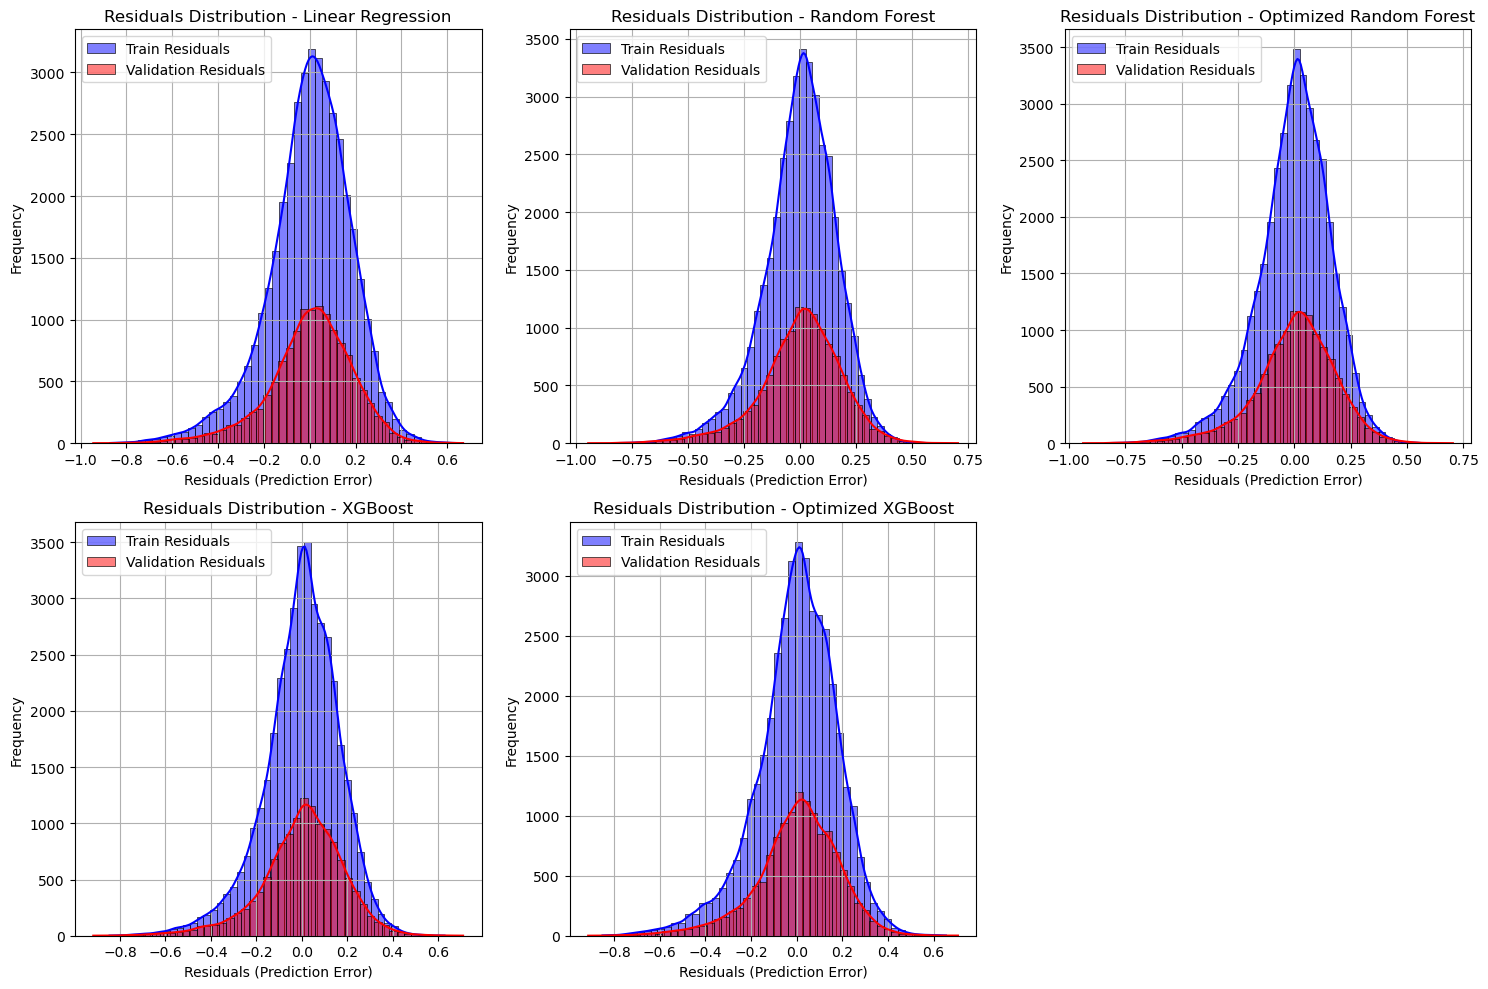

In [215]:
# Creating train vs validation residuals plots for traditional models
models = {
    "Linear Regression": joblib.load("./Save_Models/lr_model.joblib"),
    "Random Forest": joblib.load("./Save_Models/rf_model.joblib"),
    "Optimized Random Forest": joblib.load("./Save_Models/optimized_rf.joblib"),
    "XGBoost": joblib.load("./Save_Models/xgb_model.joblib"),
    "Optimized XGBoost": joblib.load("./Save_Models/optimized_xgb.joblib"),
}

# Call the function with your dataset
plot_residuals(models, X_train, X_val, y_train, y_val)

**XGBoost** and **Optimized XGBoost** show lower variance in residuals and therefore make more accurate predictions. Training and validation residuals are close which means there is good generalisation and minimal overfitting.

## 8.2 Neural Networks

In [243]:
# Define model path
model_path = "./Save_Models/"

# Prepare a results storage list
model_results = []

# Evaluate each saved model
for model_name in os.listdir(model_path): # Get models from Google Drive path
    if model_name.endswith(".keras"): # Ensures only models are loaded
        print(f"Evaluating {model_name}...")

        # Load the model with the full path
        model = load_model(os.path.join(model_path, model_name))

        train_loss, train_mae = model.evaluate(
            [X_train["userId"], X_train["movieId"], X_train.drop(columns=["userId", "movieId"])],
            y_train, verbose=0
        )
        
        val_loss, val_mae = model.evaluate(
            [X_val["userId"], X_val["movieId"], X_val.drop(columns=["userId", "movieId"])],
            y_val, verbose=0
        )

        # Store results
        model_results.append({
            "Model Name": model_name,
            "Train MSE": train_loss,
            "Train MAE": train_mae,
            "Val MSE": val_loss,
            "Val MAE": val_mae
        })

# Convert results to a DataFrame for easy viewing
results_df = pd.DataFrame(model_results)
results_df

Evaluating model1.keras...
Evaluating model2.keras...
Evaluating model3.keras...
Evaluating model4.keras...
Evaluating model5.keras...
Evaluating nn_random_search.keras...


,Model Name,Train MSE,Train MAE,Val MSE,Val MAE
0,model1.keras,0.163540,0.331511,0.161224,0.328304
1,model2.keras,0.152562,0.320216,0.150819,0.317296
2,model3.keras,0.501793,0.668490,0.505891,0.671696
3,model4.keras,0.400263,0.581308,0.405562,0.585415
4,model5.keras,0.043982,0.130160,0.050085,0.143572
5,nn_random_search.keras,0.061084,0.194071,0.064368,0.196315


In [245]:
# Convert metrics back to the original range
results_df["Train MSE (Original)"] = results_df["Train MSE"].apply(denormalize_error)
results_df["Train MAE (Original)"] = results_df["Train MAE"].apply(denormalize_error)
results_df["Val MSE (Original)"] = results_df["Val MSE"].apply(denormalize_error)
results_df["Val MAE (Original)"] = results_df["Val MAE"].apply(denormalize_error)

results_df

,Model Name,Train MSE,Train MAE,Val MSE,Val MAE,Train MSE (Original),Train MAE (Original),Val MSE (Original),Val MAE (Original)
0,model1.keras,0.163540,0.331511,0.161224,0.328304,0.735928,1.491800,0.725506,1.477368
1,model2.keras,0.152562,0.320216,0.150819,0.317296,0.686530,1.440971,0.678685,1.427833
2,model3.keras,0.501793,0.668490,0.505891,0.671696,2.258068,3.008203,2.276509,3.022634
3,model4.keras,0.400263,0.581308,0.405562,0.585415,1.801182,2.615887,1.825029,2.634365
4,model5.keras,0.043982,0.130160,0.050085,0.143572,0.197919,0.585722,0.225383,0.646076
5,nn_random_search.keras,0.061084,0.194071,0.064368,0.196315,0.274880,0.873320,0.289658,0.883418


Next we will look at the learning curves for all the neural networks trained. This will enable us to verify the stability of the models.

In [248]:
def plot_learning_curves(model_names, model_path, random_search_filename="history_random_search.pkl", num_cols=2):
    """
    Plots learning curves (Train MSE & Validation MSE) for multiple models using saved training histories.

    Parameters:
    - model_names (list): List of model names whose histories will be loaded.
    - model_path (str): Path to the directory where model history files are stored.
    - random_search_filename (str): Filename of the random search history file (default: "history_random_search.pkl").
    - num_cols (int): Number of columns for subplot layout (default: 2).

    Returns:
    - None (Displays the plot)
    """

    histories = {}

    # Load training histories for each model
    for model_name in model_names:
        file_path = os.path.join(model_path, model_name + "_history.pkl")

        if os.path.exists(file_path):
            with open(file_path, "rb") as file:
                histories[model_name] = pickle.load(file)
        else:
            print(f"Warning: History file for {model_name} not found.")

    # Load random search history separately
    random_search_path = os.path.join(model_path, random_search_filename)
    if os.path.exists(random_search_path):
        with open(random_search_path, "rb") as file:
            histories["nn_random_search"] = pickle.load(file)
    else:
        print(f"Warning: History file for {random_search_filename} not found.")

    # Determine number of models and create subplot grid
    num_models = len(histories)
    num_rows = math.ceil(num_models / num_cols)  # Calculate required rows

    fig, axes = plt.subplots(nrows=num_rows, ncols=num_cols, figsize=(12, 5 * num_rows))
    axes = axes.flatten()  # Flatten for easy iteration

    # Set consistent colors and styles
    train_color = "blue"
    val_color = "red"
    train_style = "dashed"
    val_style = "solid"

    # Plot learning curves for each model
    for idx, (model_name, history) in enumerate(histories.items()):
        ax = axes[idx]  # Select subplot

        # Plot training and validation MSE
        ax.plot(history["loss"], label="Train MSE", color=train_color, linestyle=train_style)
        ax.plot(history["val_loss"], label="Val MSE", color=val_color, linestyle=val_style)

        # Customize each subplot
        ax.set_title(f"Learning Curve - {model_name}")
        ax.set_xlabel("Epochs")
        ax.set_ylabel("Mean Squared Error (MSE)")
        ax.legend()
        ax.grid(True)

        # Set consistent y-axis scale across all plots
        ax.set_ylim([0, max(max(history["loss"]), max(history["val_loss"])) * 1.1])

    # Remove any empty subplots
    for i in range(idx + 1, len(axes)):
        fig.delaxes(axes[i])

    # Adjust layout for better visibility
    plt.tight_layout()
    plt.show()

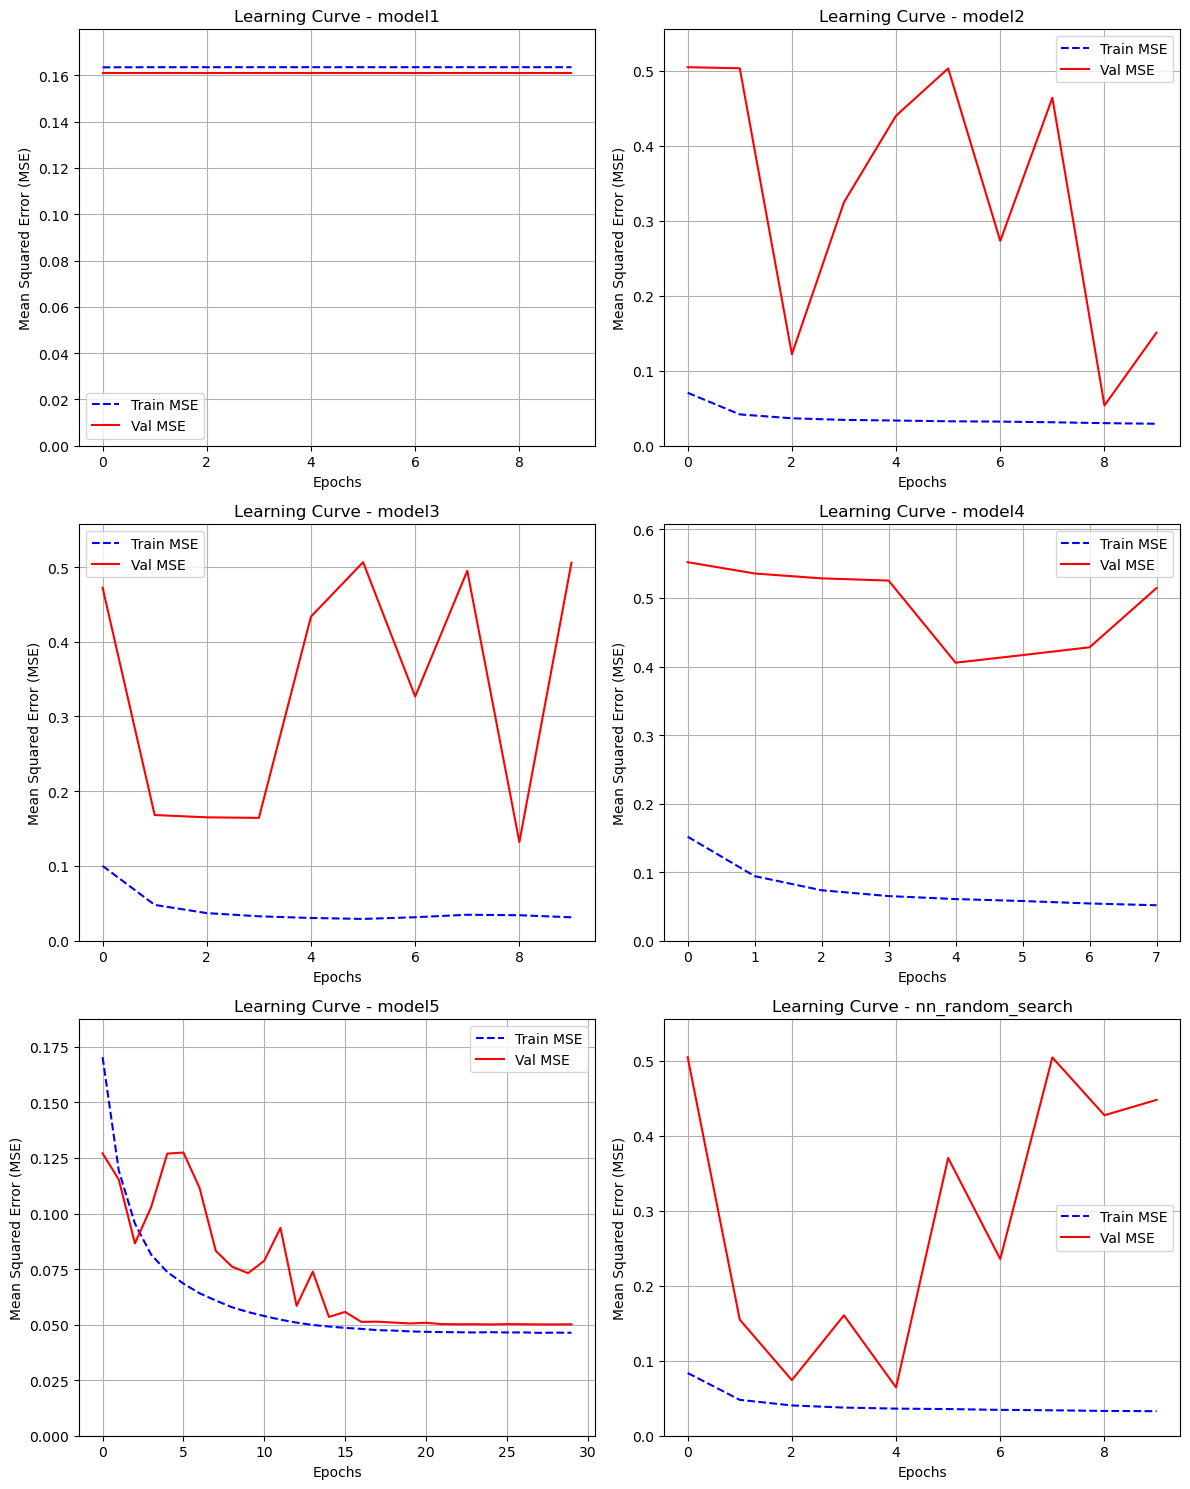

In [250]:
# List of neural network models to predict
model_names = ["model1", "model2", "model3", "model4", "model5"]

# Path to where the models are stored
model_path = "./Save_Models/"

# Plot the learning curves
plot_learning_curves(model_names, model_path)

The learning curve plot presents the following findings:
* Model 1 shows no learning
* Models 2-4 and the random search model show overfitting on the training set and very erractic errors on the validation set, implying that the models cannot generalise well
* Model 5 shows stability in both training and validation

Next, we will analyse the train vs validation residuals for all the neural network models.

Loading model: model1
1260/1260 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step
420/420 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
Loading model: model2
1260/1260 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step
420/420 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
Loading model: model3
1260/1260 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step
420/420 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
Loading model: model4
1260/1260 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step
420/420 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
Loading model: model5
1260/1260 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step
420/420 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step
Loading model: nn_random_search
1260/1260 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step
420/420 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


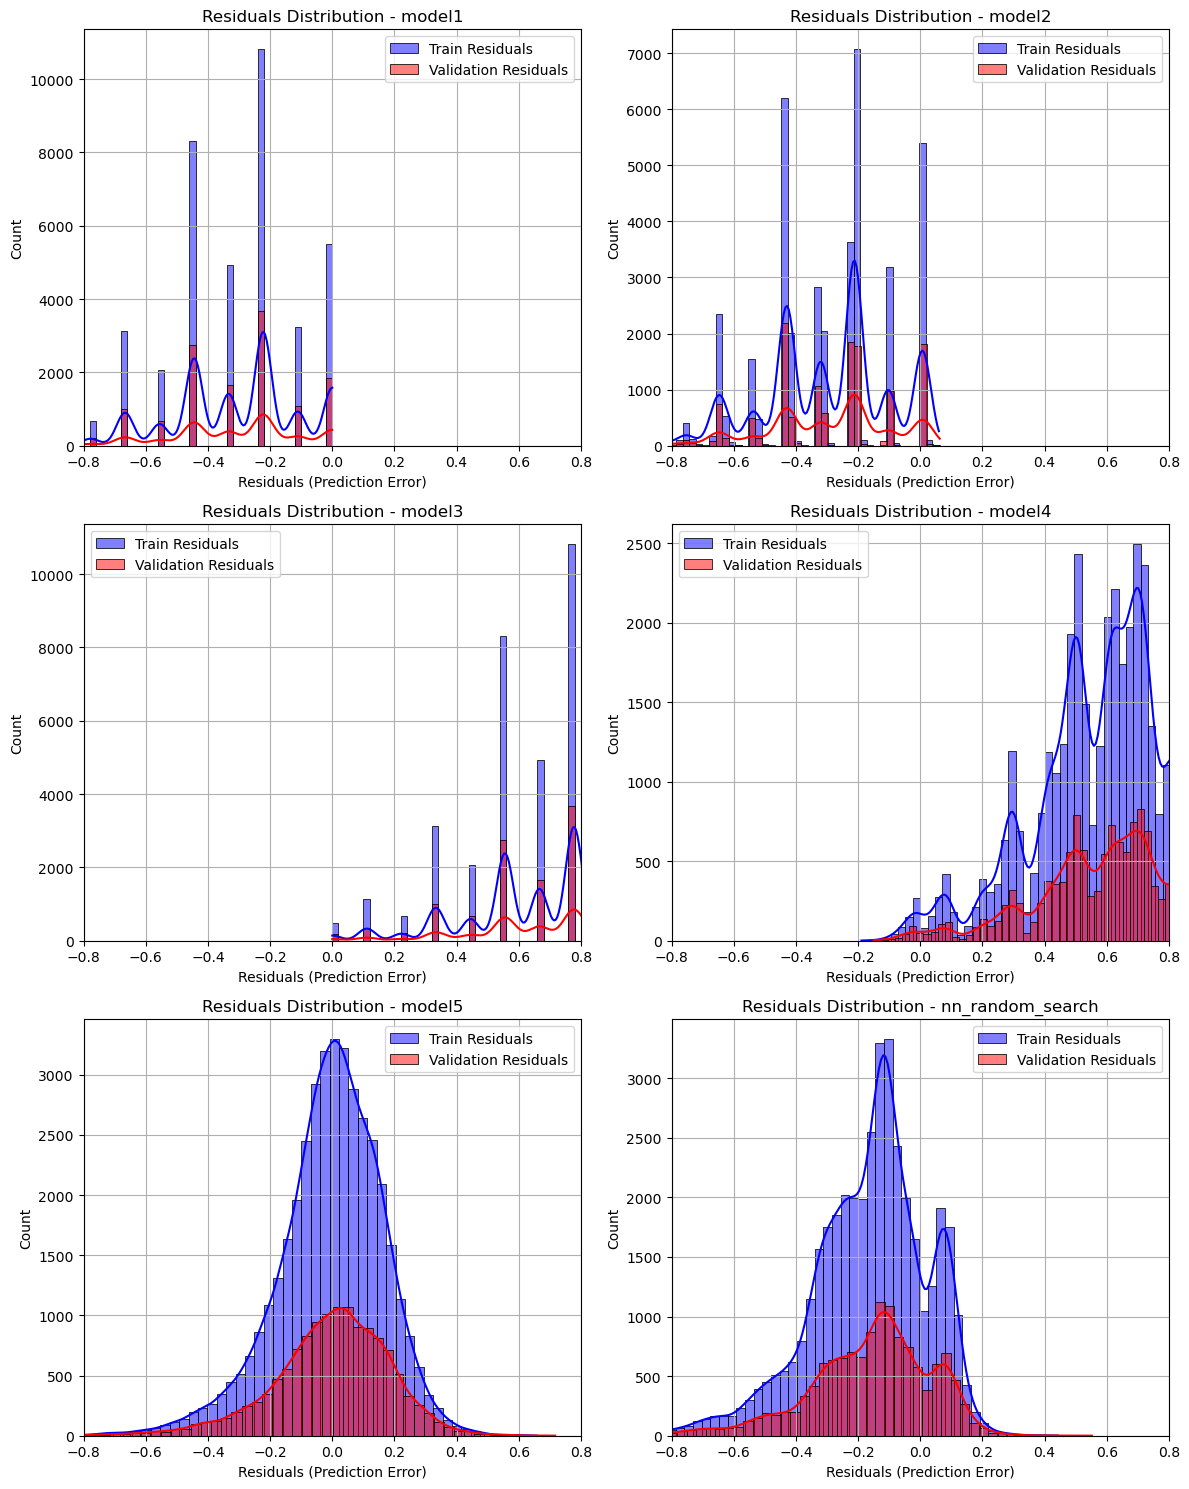

In [259]:
# List of model names including nn_random_search
model_names = ["model1", "model2", "model3", "model4", "model5", "nn_random_search"]

# Dictionary to store residuals
train_residuals_dict = {}
val_residuals_dict = {}

# Load each model and compute residuals
for model_name in model_names:
    file_path = os.path.join(model_path, model_name + ".keras")

    if os.path.exists(file_path):
        print("Loading model:", model_name)

        # Load trained model
        model = load_model(file_path)

        # Generate predictions on train and validation sets
        train_preds = model.predict([X_train["userId"], X_train["movieId"], X_train.drop(columns=["userId", "movieId"])]).flatten()
        val_preds = model.predict([X_val["userId"], X_val["movieId"], X_val.drop(columns=["userId", "movieId"])]).flatten()

        # Compute residuals (actual - predicted)
        train_residuals_dict[model_name] = y_train - train_preds
        val_residuals_dict[model_name] = y_val - val_preds

    else:
        print("Warning: Model file for {} not found.".format(model_name))

# Determine the number of rows and columns for subplots
num_models = len(model_names)
num_cols = 2  # Fixed number of columns
num_rows = (num_models // num_cols) + (num_models % num_cols > 0)  # Calculate required rows

# Create subplots for residual distributions
fig, axes = plt.subplots(nrows=num_rows, ncols=num_cols, figsize=(12, 5 * num_rows))
axes = axes.flatten()  # Flatten for easy iteration

# Plot residuals histogram for each model
for idx, model_name in enumerate(model_names):
    if model_name in train_residuals_dict and model_name in val_residuals_dict:
        ax = axes[idx]  # Select subplot
        sns.histplot(train_residuals_dict[model_name], bins=50, kde=True, color="blue", label="Train Residuals", ax=ax)
        sns.histplot(val_residuals_dict[model_name], bins=50, kde=True, color="red", label="Validation Residuals", ax=ax)

        # Customize each subplot
        ax.set_title("Residuals Distribution - {}".format(model_name))
        ax.set_xlabel("Residuals (Prediction Error)")
        ax.set_ylabel("Count")
        ax.legend()
        ax.grid(True)

        # Set consistent x-axis scale across all plots
        ax.set_xlim([-0.8, 0.8])  # Adjust as needed

# Remove empty subplots if any
for i in range(idx + 1, len(axes)):
    fig.delaxes(axes[i])

# Adjust layout for better visibility
plt.tight_layout()
plt.show()

All the models except model 5 show very erratic residuals indicating poor model performance.

## 8.3 Ensemble Model

In [200]:
ensemble_results_data = {
    "Metric": ["Train MSE", "Train MAE", "Validation MSE", "Validation MAE",
               "Train MSE (Original Scale)", "Train MAE (Original Scale)",
               "Validation MSE (Original Scale)", "Validation MAE (Original Scale)"],
    "Value": [ensemble_train_mse, ensemble_train_mae, ensemble_val_mse, ensemble_val_mae,
              ensemble_train_mse_original, ensemble_train_mae_original,
              ensemble_val_mse_original, ensemble_val_mae_original]
}

ensemble_results_df = pd.DataFrame(ensemble_results_data)
ensemble_results_df

,Metric,Value
0,Train MSE,0.029756
1,Train MAE,0.131325
2,Validation MSE,0.033562
3,Validation MAE,0.139477
4,Train MSE (Original Scale),0.133903
5,Train MAE (Original Scale),0.590961
6,Validation MSE (Original Scale),0.151028
7,Validation MAE (Original Scale),0.627646


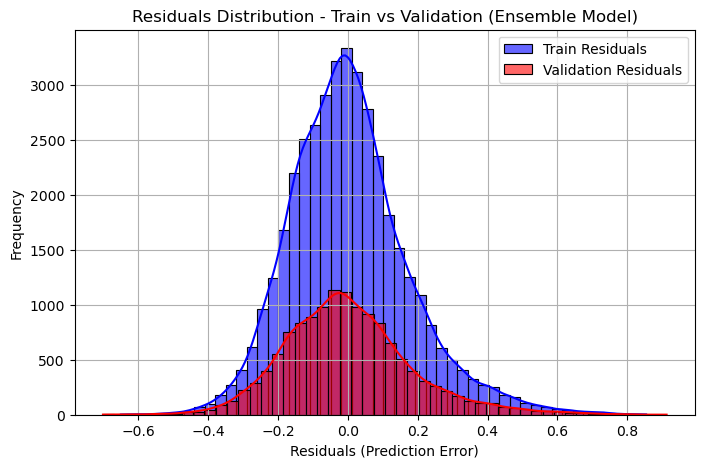

In [262]:
# Compute Residuals
ensemble_train_residuals = ensemble_train_preds - y_train
ensemble_val_residuals = ensemble_val_preds - y_val

# Plot Combined Residuals Distribution
plt.figure(figsize=(8, 5))
sns.histplot(ensemble_train_residuals, bins=50, kde=True, color="blue", label="Train Residuals", alpha=0.6)
sns.histplot(ensemble_val_residuals, bins=50, kde=True, color="red", label="Validation Residuals", alpha=0.6)
plt.title("Residuals Distribution - Train vs Validation (Ensemble Model)")
plt.xlabel("Residuals (Prediction Error)")
plt.ylabel("Frequency")
plt.legend()
plt.grid(True)

plt.show()

After analysing the visualisations for traditional machine learning models, neural networks and ensemble model, we observe that the XGBoost model performs best amongst the traditional model and model 5 is the best neural network.

Next, we will compare the ensemble, XGBoost and optimal neural network models.

In [267]:
# Compute Residuals
# Neural Network Residuals
nn_train_residuals = y_train - nn_train_preds
nn_val_residuals = y_val - nn_val_preds

# XBGoost Resdiuals
xgb_train_residuals = y_train - xgb_train_preds
xgb_val_residuals = y_val - xgb_val_preds

# Ensemble (Neural Network + XGBoost) Residuals
ensemble_train_residuals = ensemble_train_preds - y_train
ensemble_val_residuals = ensemble_val_preds - y_val

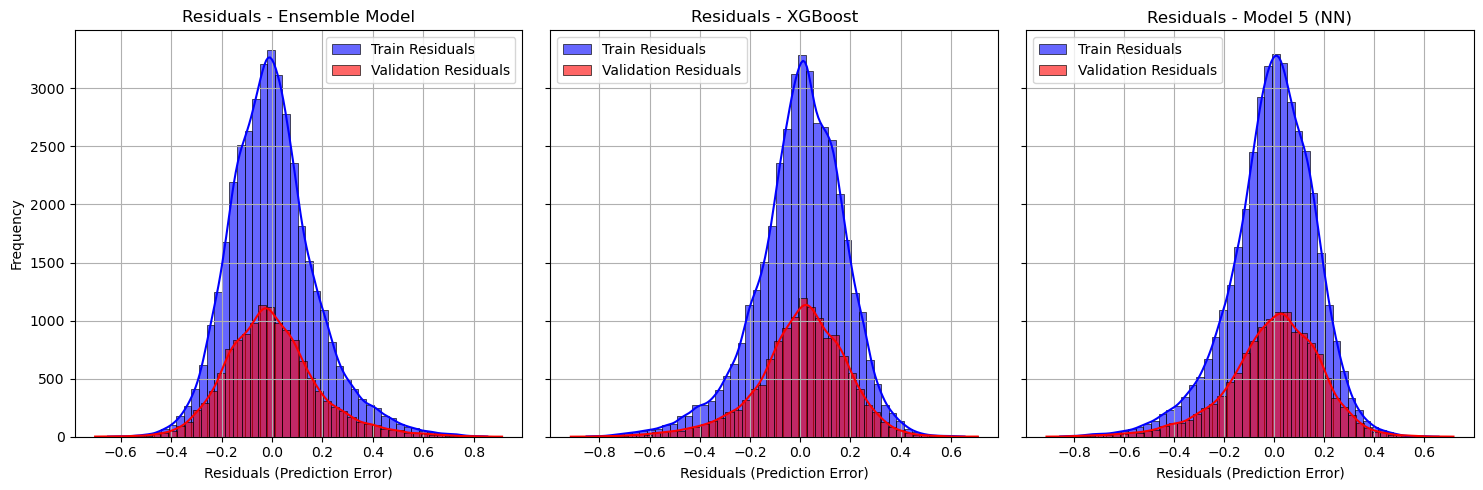

In [269]:
# Create Subplots for Residuals Comparison
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(15, 5), sharey=True)

# Ensemble Model Residuals
sns.histplot(ensemble_train_residuals, bins=50, kde=True, color="blue", label="Train Residuals", ax=axes[0], alpha=0.6)
sns.histplot(ensemble_val_residuals, bins=50, kde=True, color="red", label="Validation Residuals", ax=axes[0], alpha=0.6)
axes[0].set_title("Residuals - Ensemble Model")
axes[0].set_xlabel("Residuals (Prediction Error)")
axes[0].set_ylabel("Frequency")
axes[0].legend()
axes[0].grid(True)

# XGBoost Residuals
sns.histplot(xgb_train_residuals, bins=50, kde=True, color="blue", label="Train Residuals", ax=axes[1], alpha=0.6)
sns.histplot(xgb_val_residuals, bins=50, kde=True, color="red", label="Validation Residuals", ax=axes[1], alpha=0.6)
axes[1].set_title("Residuals - XGBoost")
axes[1].set_xlabel("Residuals (Prediction Error)")
axes[1].legend()
axes[1].grid(True)

# Model 5 (NN) Residuals
sns.histplot(nn_train_residuals, bins=50, kde=True, color="blue", label="Train Residuals", ax=axes[2], alpha=0.6)
sns.histplot(nn_val_residuals, bins=50, kde=True, color="red", label="Validation Residuals", ax=axes[2], alpha=0.6)
axes[2].set_title("Residuals - Model 5 (NN)")
axes[2].set_xlabel("Residuals (Prediction Error)")
axes[2].legend()
axes[2].grid(True)

# Adjust layout for better visibility
plt.tight_layout()
plt.show()

All 3 of these models have similar residual distributions. Therefore, we use all of them to predict the test set data and then determine the best performing model.

# 9 Testing Models

The last section of the project involves predicting ratings on the test set using the three chosen models.

## 9.1 Predicting on Test Set

In [273]:
# Model 5 (Neural Network)
nn_test_preds = nn_model5.predict([X_test["userId"], X_test["movieId"], X_test.drop(columns=["userId", "movieId"])]).flatten()

# XGBoost
xgb_test_preds = xgb_model.predict(X_test)

# Ensemble Model (Weighted Average)
w1, w2 = 0.5, 0.5  # Adjustable weights for the ensemble
ensemble_test_preds = (w1 * nn_test_preds) + (w2 * xgb_test_preds)

420/420 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step


In [275]:
# Calculating MSE and MAE
# Neural Networks MSE and MAE
nn_test_mse = mean_squared_error(y_test, nn_test_preds)
nn_test_mae = mean_absolute_error(y_test, nn_test_preds)

# XGBoost MSE and MAE
xgb_test_mse = mean_squared_error(y_test, xgb_test_preds)
xgb_test_mae = mean_absolute_error(y_test, xgb_test_preds)

# Ensemble (Neural Network + XGBoost) MSE and MAE
ensemble_test_mse = mean_squared_error(y_test, ensemble_test_preds)
ensemble_test_mae = mean_absolute_error(y_test, ensemble_test_preds)

In [277]:
# Denormalizing errors to match original rating values
nn_test_mse_original = denormalize_error(nn_test_mse)
nn_test_mae_original = denormalize_error(nn_test_mae)

xgb_test_mse_original = denormalize_error(xgb_test_mse)
xgb_test_mae_original = denormalize_error(xgb_test_mae)

ensemble_test_mse_original = denormalize_error(ensemble_test_mse)
ensemble_test_mae_original = denormalize_error(ensemble_test_mae)

## 9.2 Evaluating Test Results

In [279]:
test_results_data = {
    "Model": ["Model 5 (NN)", "XGBoost", "Ensemble"],
    "Test MSE": [nn_test_mse, xgb_test_mse, ensemble_test_mse],
    "Test MAE": [nn_test_mae, xgb_test_mae, ensemble_test_mae],
    "Test MSE (Original Scale)": [nn_test_mse_original, xgb_test_mse_original, ensemble_test_mse_original],
    "Test MAE (Original Scale)": [nn_test_mae_original, xgb_test_mae_original, ensemble_test_mae_original]
}

test_df = pd.DataFrame(test_results_data)
test_df

,Model,Test MSE,Test MAE,Test MSE (Original Scale),Test MAE (Original Scale)
0,Model 5 (NN),0.035453,0.144288,0.159538,0.649294
1,XGBoost,0.032757,0.138429,0.147405,0.622931
2,Ensemble,0.033600,0.140274,0.151200,0.631233


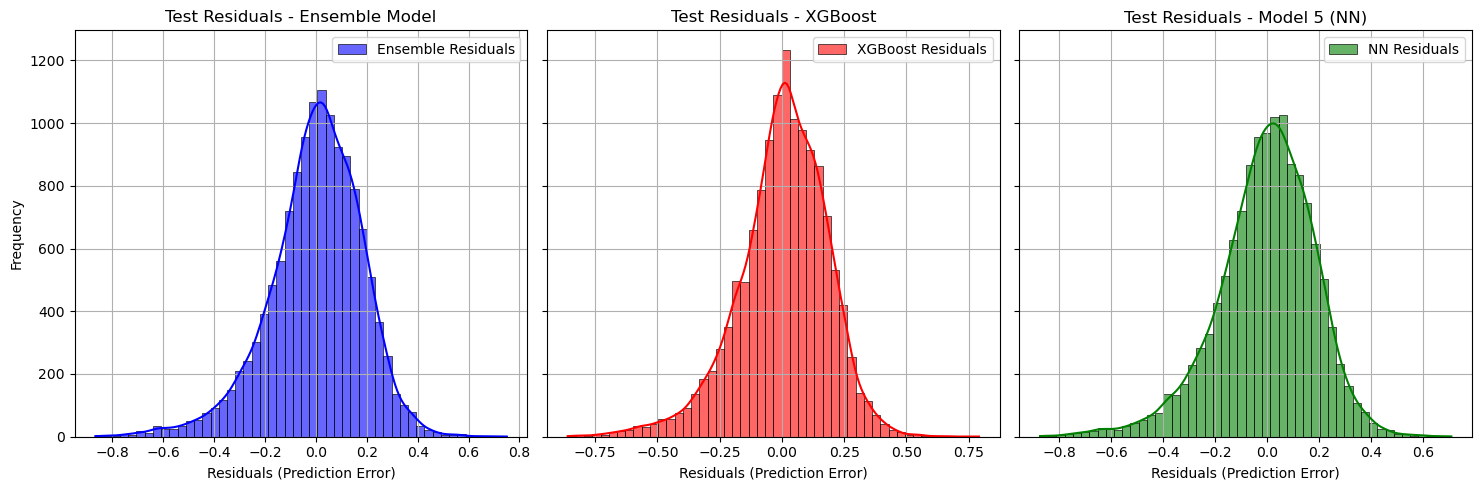

In [284]:
# Visualize Residual Distributions for Test Set
nn_test_residuals = y_test - nn_test_preds
xgb_test_residuals = y_test - xgb_test_preds
ensemble_test_residuals = y_test - ensemble_test_preds

# Create Subplots for Residuals Comparison
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(15, 5), sharey=True)

# Ensemble Model Residuals
sns.histplot(ensemble_test_residuals, bins=50, kde=True, color="blue", label="Ensemble Residuals", ax=axes[0], alpha=0.6)
axes[0].set_title("Test Residuals - Ensemble Model")
axes[0].set_xlabel("Residuals (Prediction Error)")
axes[0].set_ylabel("Frequency")
axes[0].legend()
axes[0].grid(True)

# XGBoost Residuals
sns.histplot(xgb_test_residuals, bins=50, kde=True, color="red", label="XGBoost Residuals", ax=axes[1], alpha=0.6)
axes[1].set_title("Test Residuals - XGBoost")
axes[1].set_xlabel("Residuals (Prediction Error)")
axes[1].legend()
axes[1].grid(True)

# Model 5 (NN) Residuals
sns.histplot(nn_test_residuals, bins=50, kde=True, color="green", label="NN Residuals", ax=axes[2], alpha=0.6)
axes[2].set_title("Test Residuals - Model 5 (NN)")
axes[2].set_xlabel("Residuals (Prediction Error)")
axes[2].legend()
axes[2].grid(True)

# Adjust layout
plt.tight_layout()
plt.show()

While residual distributions are still very similar, the **XGBoost** model shows the narrowest residuals and thus performs the best

In [286]:
import scipy.stats as st

# Function to compute confidence intervals
def compute_ci(predictions, actuals, confidence=0.95):
    residuals = actuals - predictions
    mean_error = np.mean(residuals)
    std_error = np.std(residuals, ddof=1)  # Standard deviation of residuals
    n = len(residuals)

    # Compute margin of error
    margin_of_error = st.t.ppf((1 + confidence) / 2, df=n-1) * (std_error / np.sqrt(n))

    # Compute lower and upper bounds
    lower_bound = mean_error - margin_of_error
    upper_bound = mean_error + margin_of_error

    return mean_error, margin_of_error

# Function to compute RMSE
def calculate_rmse(y_true, y_pred):
    """Compute Root Mean Squared Error (RMSE)."""
    mse = mean_squared_error(y_true, y_pred)  # Calculate Mean Squared Error
    rmse = np.sqrt(mse)  # Compute RMSE
    return rmse

# Function to compute R-squared (R2) Score
def calculate_r2(y_true, y_pred):
    """Compute R-squared (R2) Score."""
    return r2_score(y_true, y_pred)


In [288]:
# Denormalize predictions
nn_test_preds_original = denormalize_error(nn_test_preds)
xgb_test_preds_original = denormalize_error(xgb_test_preds)
ensemble_test_preds_original = denormalize_error(ensemble_test_preds)
y_test_original = denormalize_error(y_test)  # Denormalize ground truth

# Compute RMSE, R², and Confidence Intervals on denormalized values
nn_mean_error, nn_margin = compute_ci(nn_test_preds_original, y_test_original)
nn_rmse = calculate_rmse(y_test_original, nn_test_preds_original)
nn_r2 = calculate_r2(y_test_original, nn_test_preds_original)

xgb_mean_error, xgb_margin = compute_ci(xgb_test_preds_original, y_test_original)
xgb_rmse = calculate_rmse(y_test_original, xgb_test_preds_original)
xgb_r2 = calculate_r2(y_test_original, xgb_test_preds_original)

ensemble_mean_error, ensemble_margin = compute_ci(ensemble_test_preds_original, y_test_original)
ensemble_rmse = calculate_rmse(y_test_original, ensemble_test_preds_original)
ensemble_r2 = calculate_r2(y_test_original, ensemble_test_preds_original)

# Create a DataFrame for Display
ci_data = {
    "Model": ["Model 5 (NN)", "XGBoost", "Ensemble"],
    "Mean Error (± Margin)": [
        f"{nn_mean_error:.4f} ± {nn_margin:.4f}",
        f"{xgb_mean_error:.4f} ± {xgb_margin:.4f}",
        f"{ensemble_mean_error:.4f} ± {ensemble_margin:.4f}"
    ],
    "RMSE": [
        f"{nn_rmse:.4f}",
        f"{xgb_rmse:.4f}",
        f"{ensemble_rmse:.4f}"
    ],
    "R2 Score": [
        f"{nn_r2:.4f}",
        f"{xgb_r2:.4f}",
        f"{ensemble_r2:.4f}"
    ]
}

ci_df = pd.DataFrame(ci_data)
ci_df

,Model,Mean Error (± Margin),RMSE,R2 Score
0,Model 5 (NN),-0.0212 ± 0.0143,0.8473,0.3584
1,XGBoost,0.0109 ± 0.0138,0.8144,0.4072
2,Ensemble,-0.0052 ± 0.0140,0.8249,0.3920


Again, this reinforces that the XGBoost model is the best performing as it accounts for 40% of the variance in ratings (R2 Score).

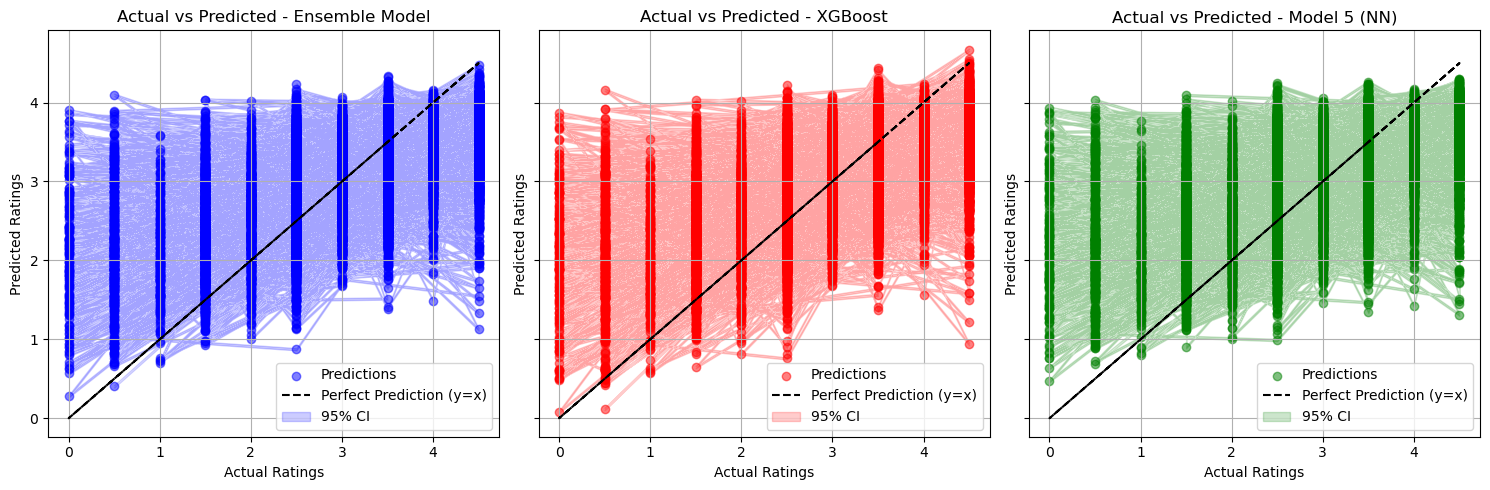

In [290]:
# Visualizing Confidence Intervals as Shaded Areas on Actual vs Predicted Plots
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(15, 5), sharey=True)

# Define models for plotting
models = [
    ("Ensemble Model", ensemble_test_preds_original, ensemble_mean_error, ensemble_margin, "blue"),
    ("XGBoost", xgb_test_preds_original, xgb_mean_error, xgb_margin, "red"),
    ("Model 5 (NN)", nn_test_preds_original, nn_mean_error, nn_margin, "green")
]

# Plot actual vs predicted with confidence intervals
for i, (title, preds, mean_err, margin, color) in enumerate(models):
    axes[i].scatter(y_test_original, preds, color=color, alpha=0.5, label="Predictions")
    axes[i].plot(y_test_original, y_test_original, linestyle="dashed", color="black", label="Perfect Prediction (y=x)")

    # Add shaded confidence interval
    lower_bound = preds - margin
    upper_bound = preds + margin
    axes[i].fill_between(y_test_original, lower_bound, upper_bound, color=color, alpha=0.2, label="95% CI")

    axes[i].set_title(f"Actual vs Predicted - {title}")
    axes[i].set_xlabel("Actual Ratings")
    axes[i].set_ylabel("Predicted Ratings")
    axes[i].grid(True)
    axes[i].legend()

# Adjust layout
plt.tight_layout()
plt.show()

The actual vs. predicted 
plots highlight a similar trend, where XGBoost’s predictions were more closely aligned
with the perfect prediction line, while the neural network had a larger variance.